# House Prices
## Data Science

Welcome to the Data Science Project. This notebook provides you with the basic commands to start your journey. This project is going to be framed using the **CRISP-ML(Q)** (CRoss Industry Standard Process in Machine Learning with Quality Assurance).

<img src="Img/CRISP-ML(Q).png" width=800 />

https://ml-ops.org/content/crisp-ml

# 1. Business & Data Understanding

Developing machine learning applications starts with identifying the scope of the ML application, the success criteria, and a data quality verification. The goal of this first phase is to ensure the feasibility of the project.

Thus we invite you to read about the use case => https://www.kaggle.com/c/house-prices-advanced-regression-techniques
Kaggle provides great tutorials about this use case. We invite you to read them.

Furthermore, we invite you to reflect on your own experience and knowledge about what makes the price of a home.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

In [2]:
train_raw = pd.read_csv('Data/train.csv', index_col = 'Id')
validation_raw = pd.read_csv('Data/test.csv', index_col = 'Id')

## 1.1 First look at the dataset

Let's have a look at the dataset we imported.

In [3]:
train_raw.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

### The dependant variable

The first thing to do is to have a look at our target variable, namely **SalePrice**. We shall need to predict it for the test dataset.

In [4]:
# descriptive statistics summary
train_raw['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

This isn't very visual, but we can already see that the lower quartile is around 130k, the median at 163k, the mean at 180k and the upper quartile at 214k. This means the distribution is skewed.

Let's plot the distribution to have a look.

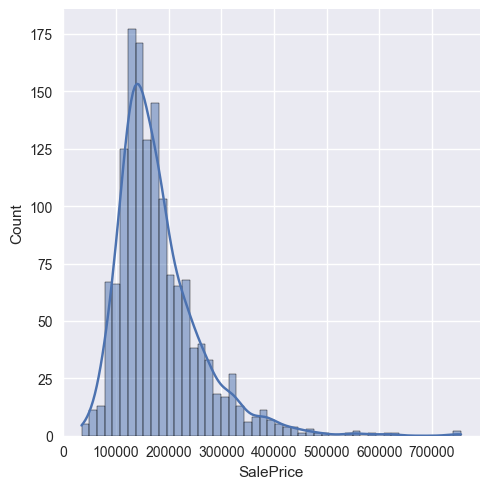

In [5]:
# distribution plot with normal fit
ax = sns.displot(data = train_raw['SalePrice'], kde=True)
plt.show()

We can see the distribution is completely skewed. Let's do a quick hypothesis testing just to confirm it's not normal. 

In our case, the null hypothesis states the variable **SalePrice** comes from a normally distributed population. We need to perform the __Shapiro-Wilk test__ in order to reject our null hypothesis. 

https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

The assocated p-value is : 3.2061412312022114e-33
With a threshold α = 0.05, we reject the null hypothesis


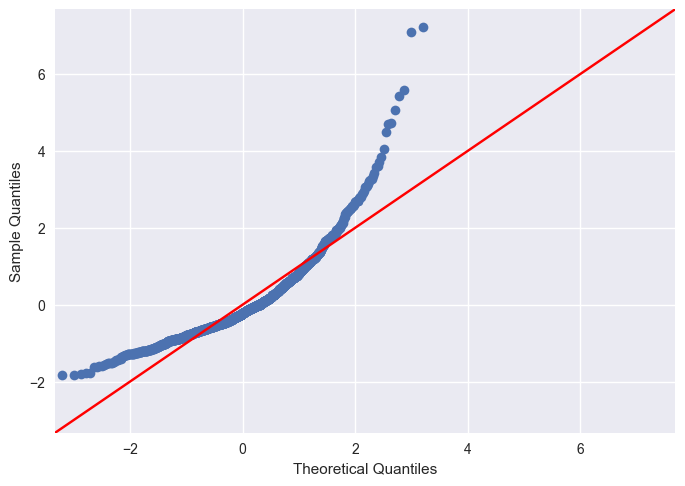

In [6]:
# Shapiro-Wilk Test for normality together with the Q-Q plot
alpha = 0.05
W, p = stats.shapiro(train_raw['SalePrice'])

print('The assocated p-value is : ' + str(p))

if p < alpha : 
    print('With a threshold α = ' + str(alpha) + ', we reject the null hypothesis')
else : 
    print('With a threshold α = ' + str(alpha) + ', we fail to reject the null hypothesis')
    
qqplot(train_raw['SalePrice'], dist = stats.distributions.norm, fit = True, line = '45')
plt.show()

The __Shapiro-Wilk test__ together with the **Q-Q Plot** confirms the variable does not come from a normally distributed population.

https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot

On Kaggle, it's said that "_Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the **logarithm** of the predicted value and the **logarithm** of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)_" 

Hence let's see how does a log normal fit look like!

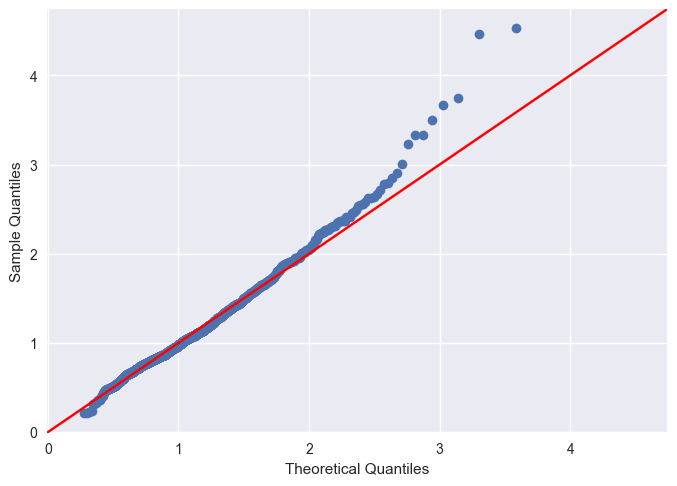

In [7]:
qqplot(train_raw['SalePrice'], dist = stats.distributions.lognorm, fit = True, line = '45')
plt.show()

It's still not perfect. Do you see these extreme values deviating on the upper right? However, it's already way better. We will probably need to remove these extreme values since regression algorithms don't behave well with these. 

Let's transform our trarget variable SalePrice using the mapping

$$ x \mapsto \log(1 + x) $$

This is exactly the NumPy function **log1p**. We write the **logarithm of SalePrice** in a dedicated variable **y**.

https://numpy.org/doc/stable/reference/generated/numpy.log1p.html

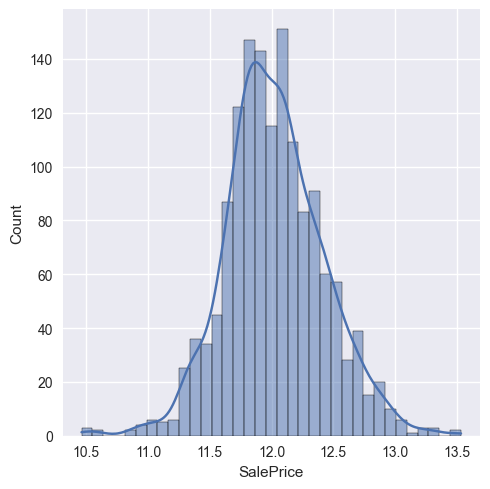

In [8]:
# new variable target which is the logarithm of the SalePrice
target = np.log1p(train_raw['SalePrice'])

# distribution plot
ax = sns.displot(data = target, kde=True)
plt.show()

### The independant variables

Now it's time to analyse the independant variables and their interaction with the **SalePrice**. We will probably need to do some basic data cleaning first.

(￣o￣) . z Z

If you read carefully the description of the variables, you will see that there are three kinds of variables in the dataset :

1. Qualitative. 
2. Quantitative,
3. Date.

_Remark._ The documentation instructs us that variables **OverallQual** and **OverallCond** are qualitative. However, we shall consider them as quantitative variables since they are already represented with values on an ordinal scale. 

http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [9]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

In order to clean the data entirely, let's concatenate the **train_raw** together with the **test_raw**

In [10]:
data_raw = pd.concat([train_raw, validation_raw])

## 1.2 Imputing missing values

Let us first have a look at the missing variables. The following function will plot the number of NA per columns.

In [11]:
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

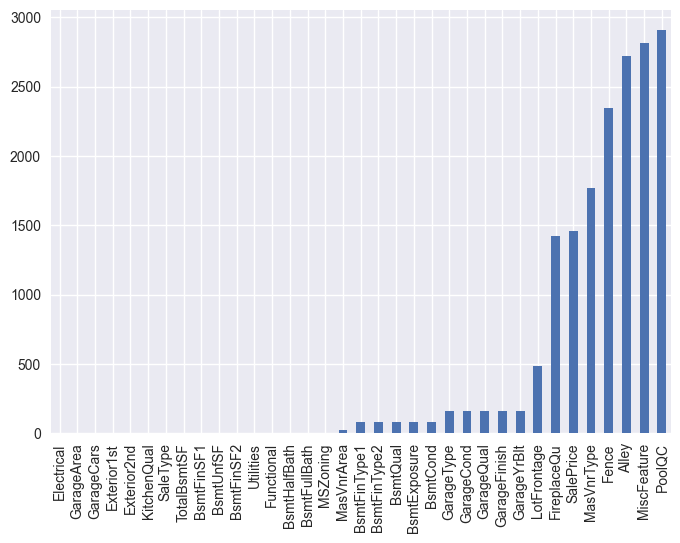

In [12]:
plot_missing(data_raw)

A further analysis can show that the **test.csv** contains more columns with missing values. For instance, the variable **TotalBSMSF** don't have any missing values in the training dataset, while on the holdout it does. This is typical! The training dataset is often cleaner than the production dataset.

This is another reason why we put the datasets together. It's more easy to handle such phenomenon for our data analysis.

We are now going to define a strategy to "fill the blanks". It's always good to check with the business why there are missing or abnormal values. The documentation reveals that missing values are there for a good reason, because the feature does not exist.

### Quantitative variables

The strategy that makes the most sens is to fill the blanks with zeros, because a missing value in the data indicates there is none.

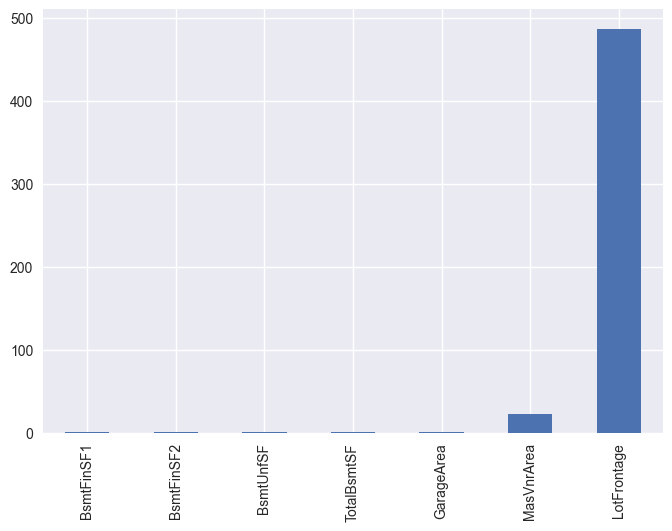

In [13]:
plot_missing(data_raw[quantitative])

In [14]:
# For quantitative variables, we will fill columns with 0
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

### Qualitative variables

The strategy that makes sens for qualitative variables is to fill the blank with 'NA' value like one would do in Business Intelligence.

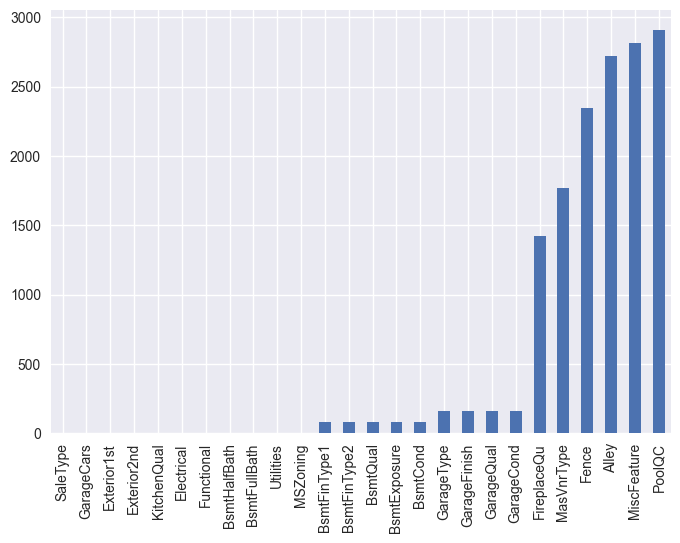

In [15]:
plot_missing(data_raw[qualitative])

We don't need to define a particular function for that because we are using the previously defined **fill_missing_with_constant** function.

### Date variables

We can see that the only date variable which has missing values is the **GarageYrBlt**, probably because the house doesn't have a garage. Thus let's replace this date with the **YearBuilt** which kind of makes sens from a business perspective.

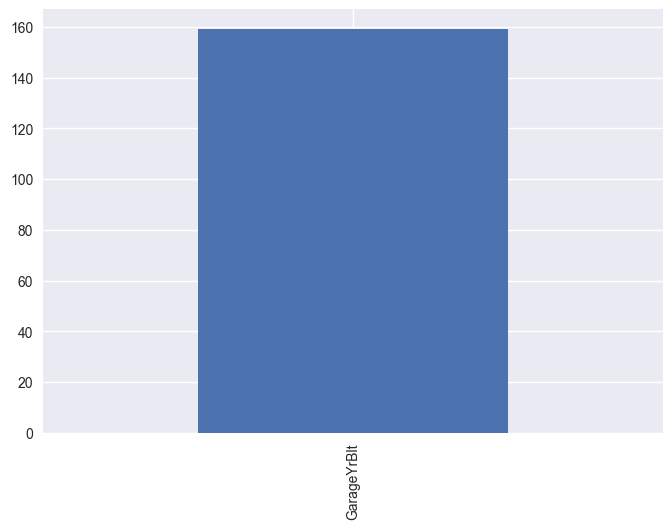

In [16]:
plot_missing(data_raw[date])

In [17]:
# For date variables, we will fill the missing values using the values from another column
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

## 1.3 Basic transform

Since the sales range from 2006 to 2010, it would make sens to compute the number of years since the house was built, remodeled, etc.

In [18]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

## 1.4 Run the cleaning process
We shall now perform the cleaning of the dataset and explore the data.

In [19]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

Let's run the cleaning process.

In [20]:
data_clean = clean(data_raw)

data_clean.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave    NA      Reg   
2           20       RL         80.0     9600   Pave    NA      Reg   
3           60       RL         68.0    11250   Pave    NA      IR1   
4           70       RL         60.0     9550   Pave    NA      IR1   
5           60       RL         84.0    14260   Pave    NA      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
2          Lvl    AllPub       FR2  ...        0     NA    NA          NA   
3          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
4          Lvl    AllPub    Corner  ...        0     NA    NA          NA   
5          Lvl    AllPub       FR2  ...        0     NA    NA          NA   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal   208500.0  
2        0      5    2007        WD         Normal   181500.0  
3        0      9    2008        WD         Normal   223500.0  
4        0      2    2006        WD        Abnorml   140000.0  
5        0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

## 1.5 Exploratory Data Understanding

We shall now perform the EDA and ideate on how we are going to solve this case. We have two types of variables, the categorical variables and the numeric variables. Furthermore, we need to split our cleaned dataset back into a training dataset and a validation dataset as before.

In [21]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
               'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
               'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
               'MiscFeature', 'SaleType', 'SaleCondition', 'YrSold', 'MoSold']

numeric = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
           'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

# Split of the clean dataset into train & validation
train_clean = data_clean[data_clean.index.isin(train_raw.index)]
validation_clean = data_clean[data_clean.index.isin(validation_raw.index)]

### Numeric variables analysis

Let's first have a look at the numeric one. It's quite standard to look at the correlation between each numeric variable together with our target variable, i.e. the **logarithm of SalePrice**. Beware to not perform a correlation with the **SalePrice** itself, because the link is probably not linear as we've seen previously.

In [22]:
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

Let's then have a look at the correlations between the numeric variables and the **logarithm of SalePrice** over the train_clean dataset.

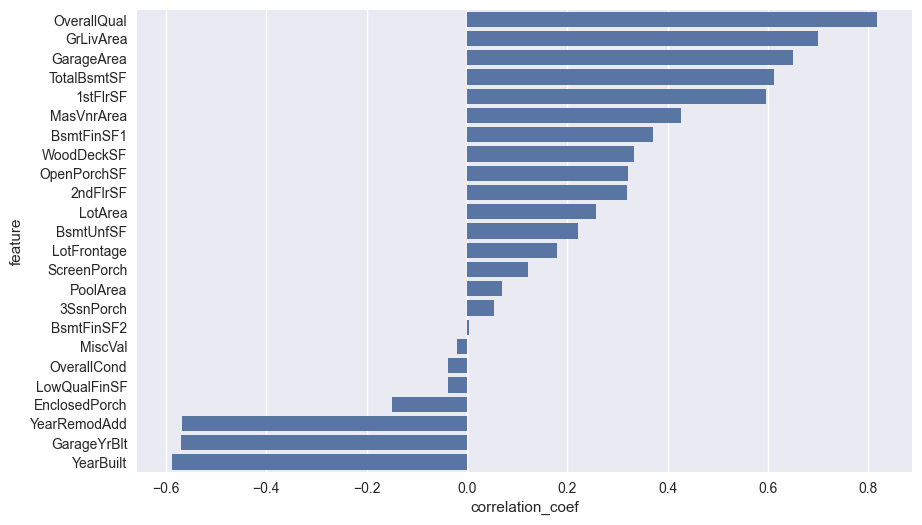

In [23]:
cor = correlation(target, train_clean, numeric, method = 'pearson')

Correlation value itself can be deceiving, one must plot the scaterplots. Let's plot all the scatter plots for theses numeric features.

In [24]:
def scatter_plots(y, X, features) :
    
    for f in features :
        x = X[f]
        
        plt.title('Correlation ' + y.name + ' & ' + x.name)
        sns.regplot(x = x.name, y = y.name, data = pd.concat([x, y], axis = 1), x_jitter = .05)
        
        plt.show()

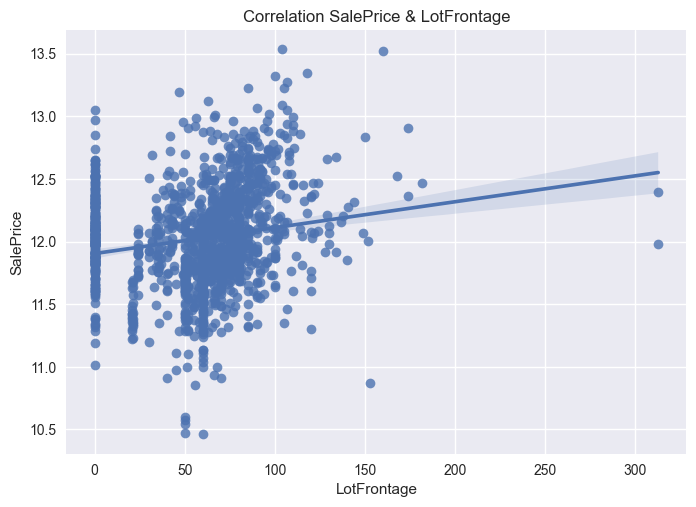

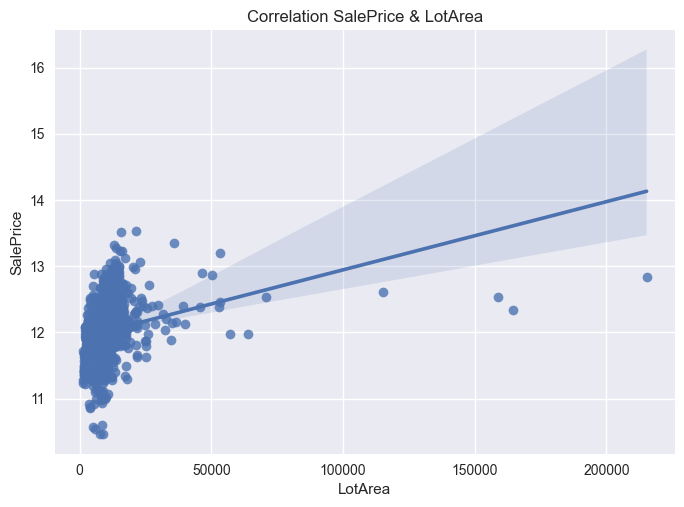

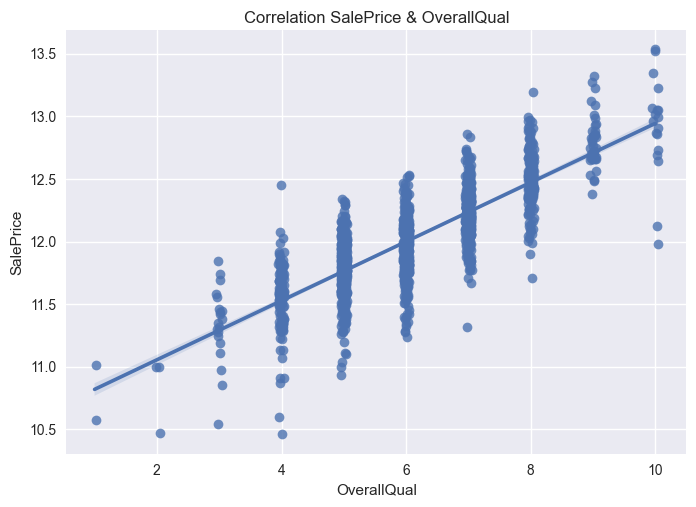

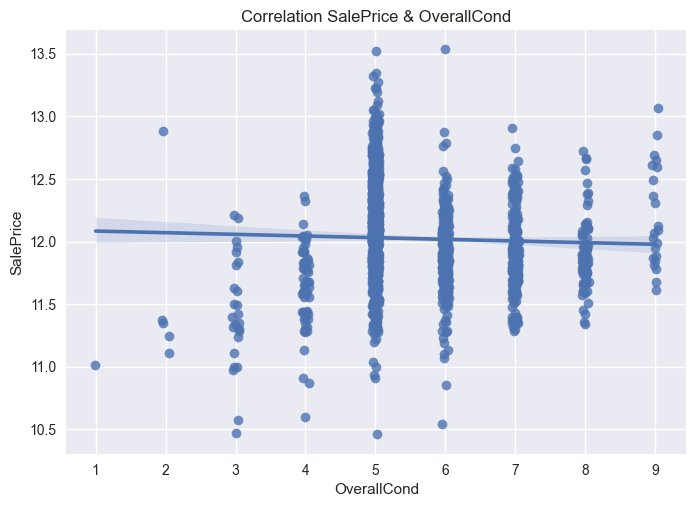

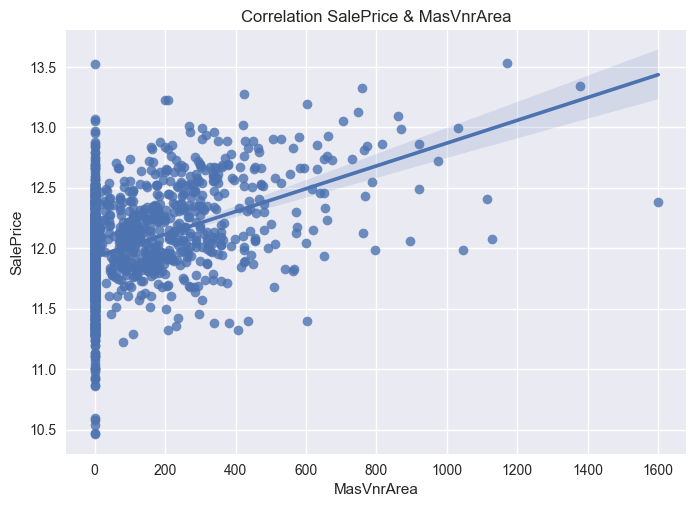

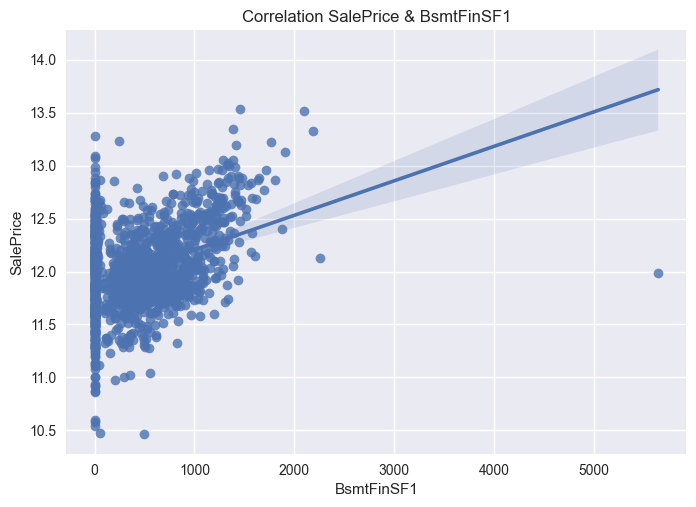

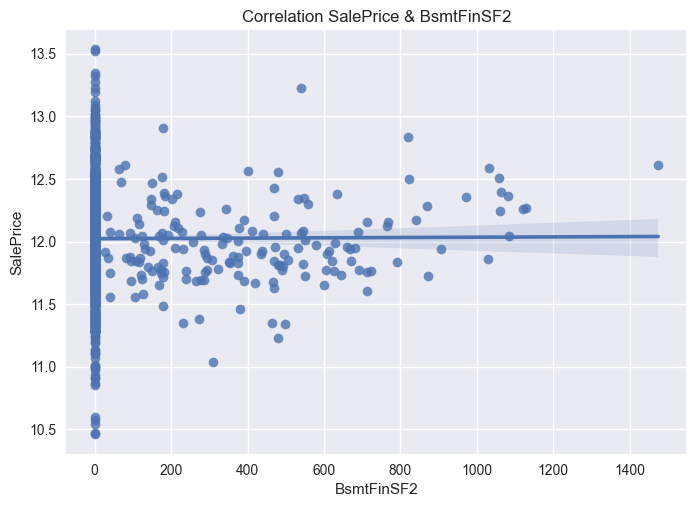

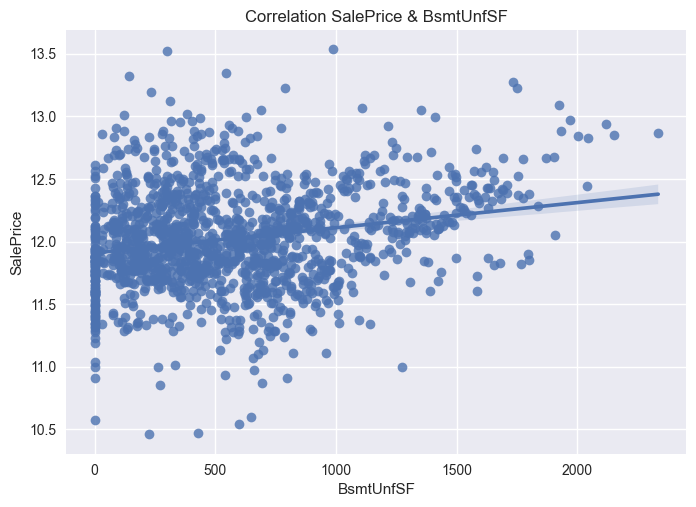

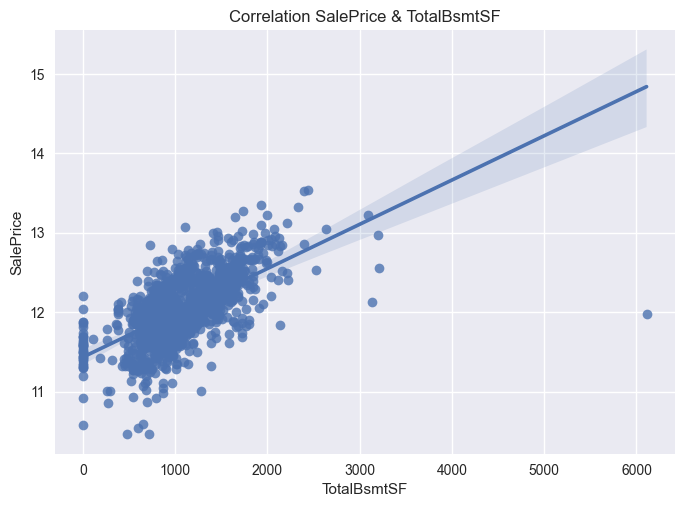

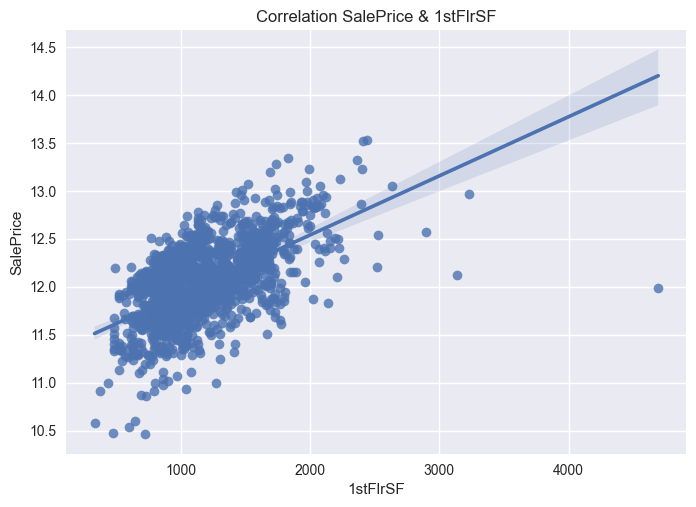

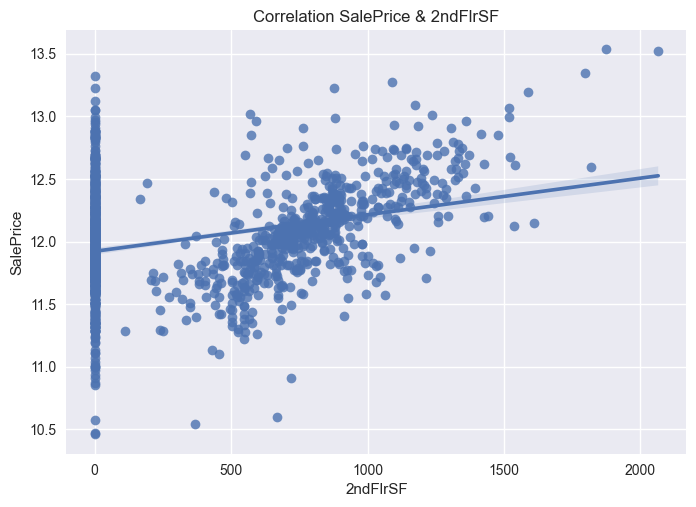

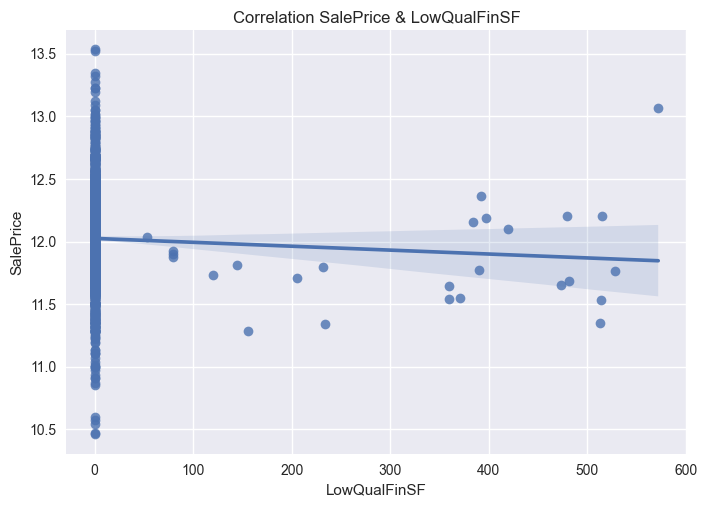

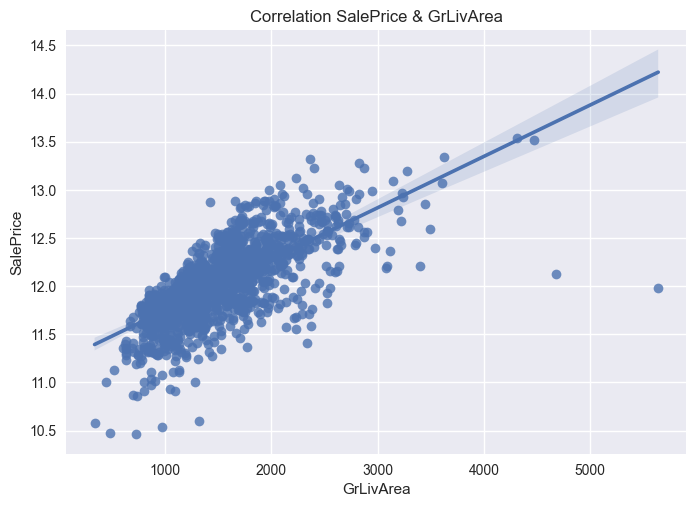

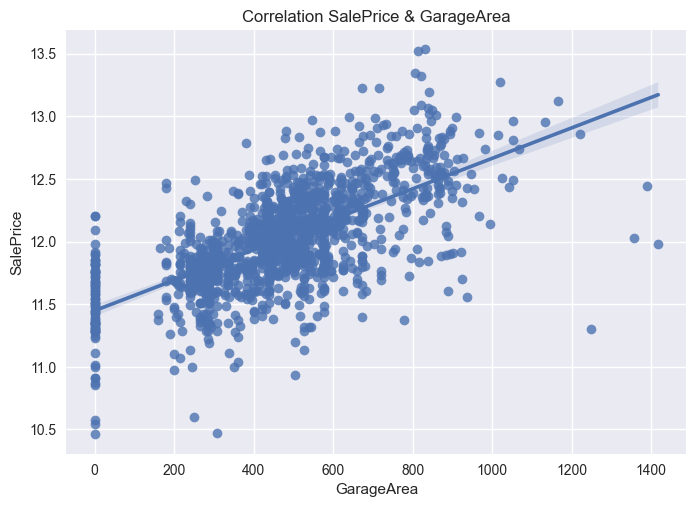

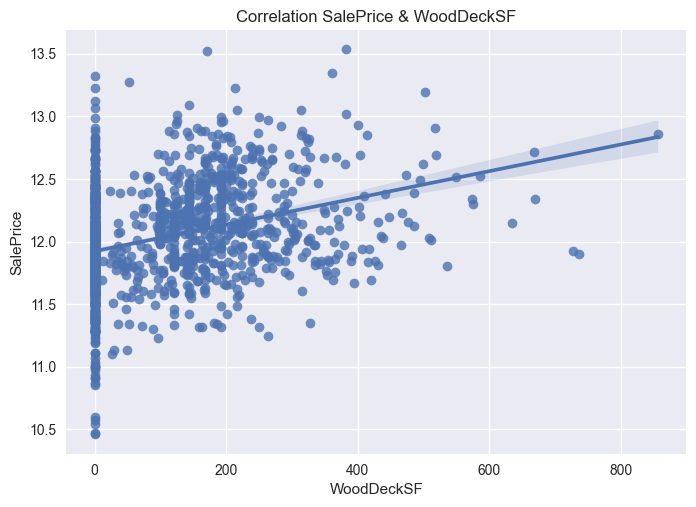

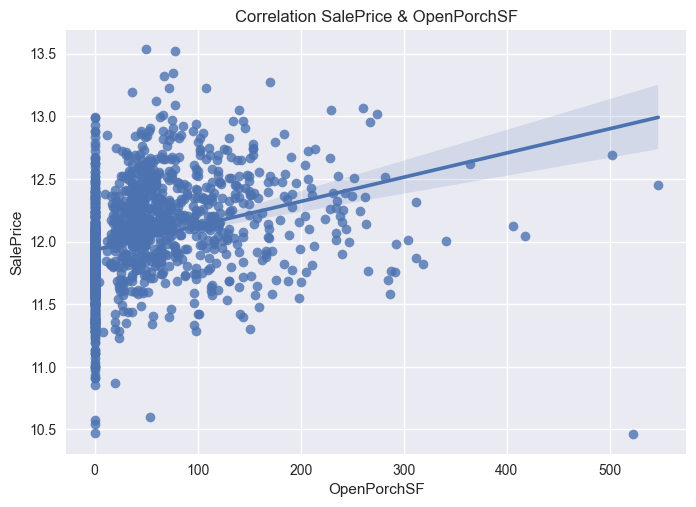

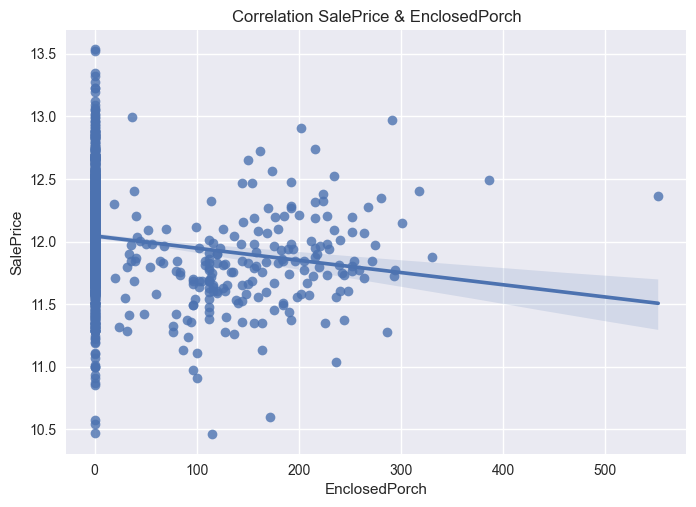

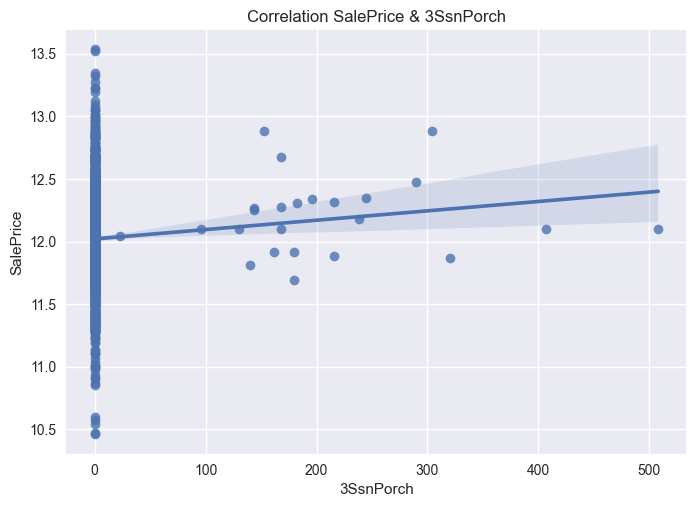

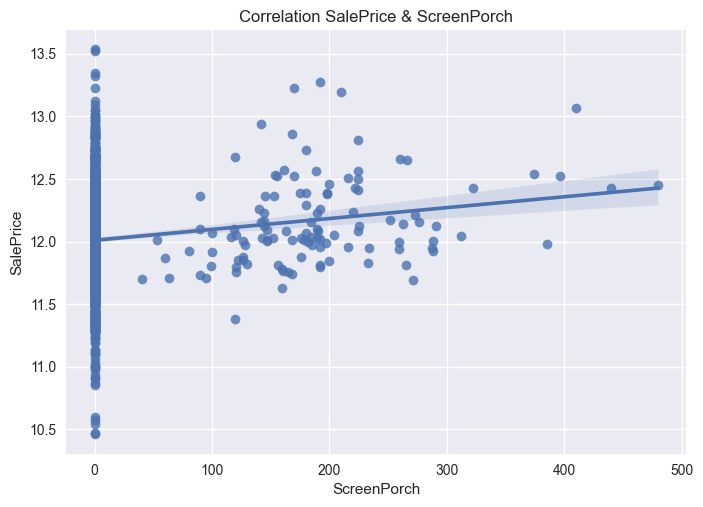

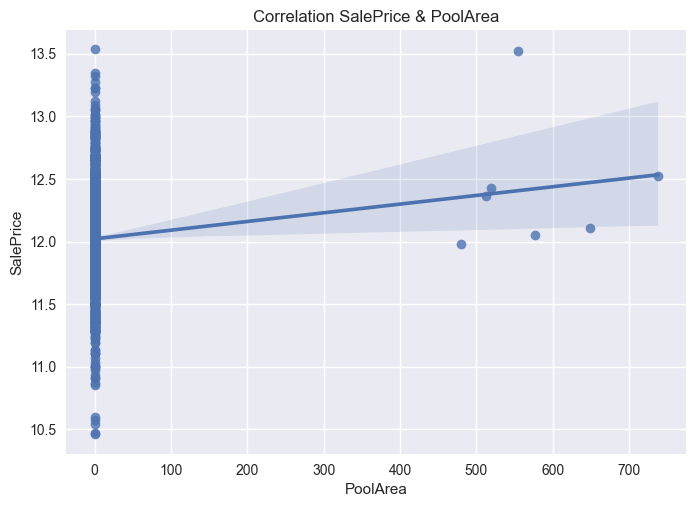

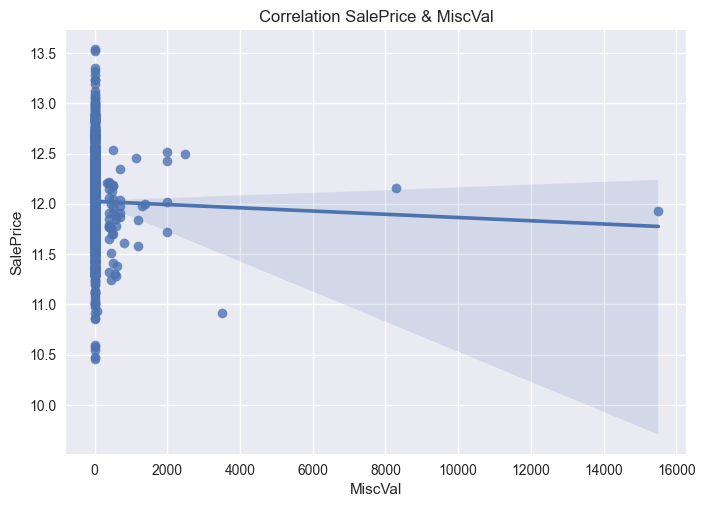

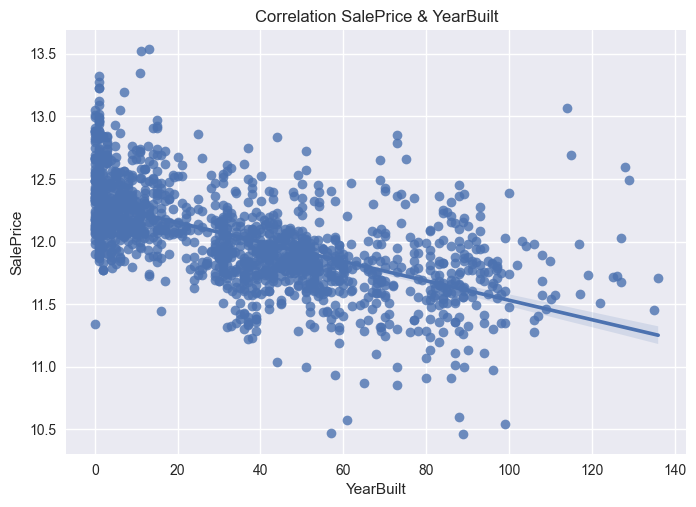

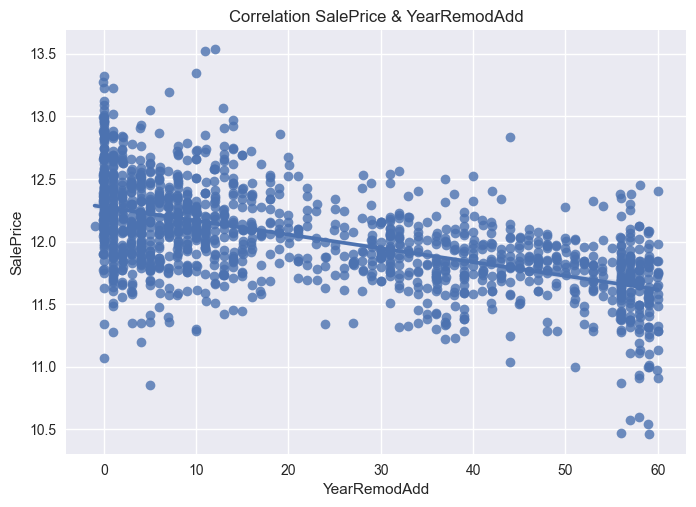

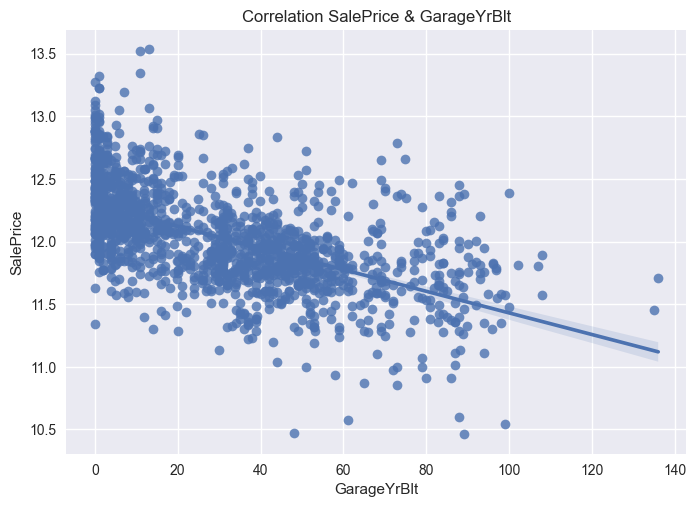

In [25]:
scatter_plots(target, train_clean, numeric)

### Categorical variables analysis

For categorical variables, we can't perform a correlation for obvious reasons. Thus, we need to perform an ANOVA (https://en.wikipedia.org/wiki/Analysis_of_variance) which is the counterpart in the case when we want to understand the link between a categorical variable with a numeric one.

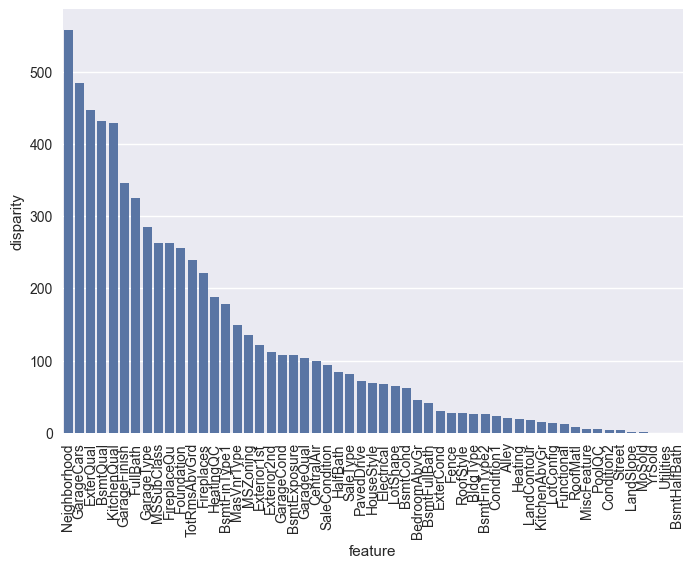

In [26]:
def anova(y, X, features):
    
    anova = pd.DataFrame()
    anova['feature'] = features
    pvals = []
    
    for f in features:
        
        samples = []
        
        for cls in X[f].unique():
            
            s = y[X[f] == cls].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
        
    anova['pval'] = pvals
    anova = anova.sort_values('pval')
    
    anova['disparity'] = np.log(1. / anova['pval'].values)

    sns.barplot(data = anova, x = 'feature', y = 'disparity')
    x = plt.xticks(rotation=90)
    
    return anova

anova = anova(target, train_clean, categorical)

In [27]:
def box_plots(y, X, features) :
    
    for f in features :
        x = X[f]
    
        plt.title('Box plot ' + y.name + ' & ' + x.name)
        sns.boxplot(x = x, y = y)
        x = plt.xticks(rotation = 90)
        
        plt.show()

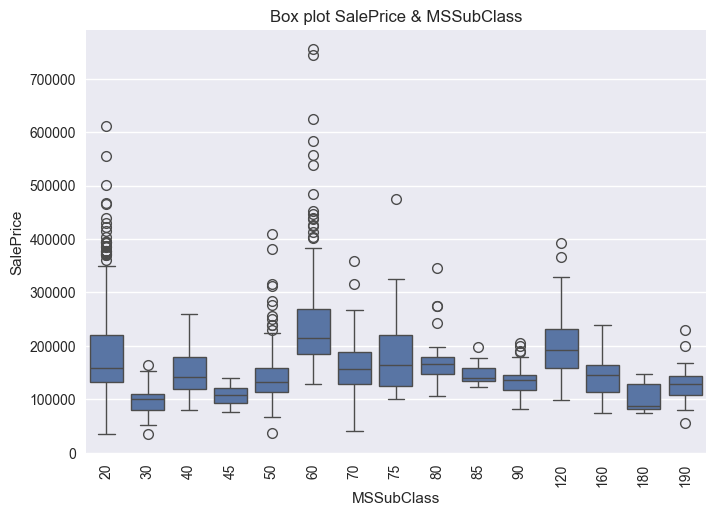

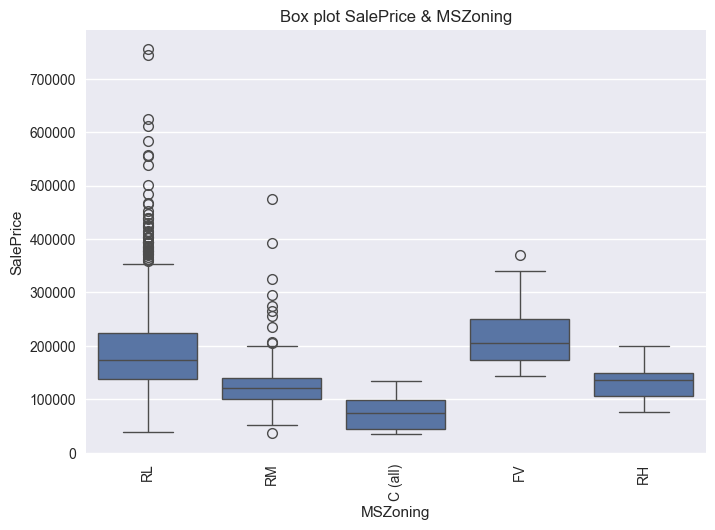

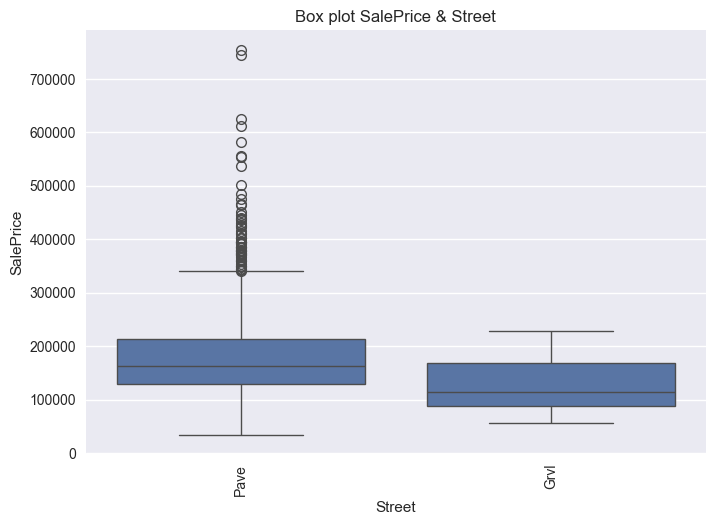

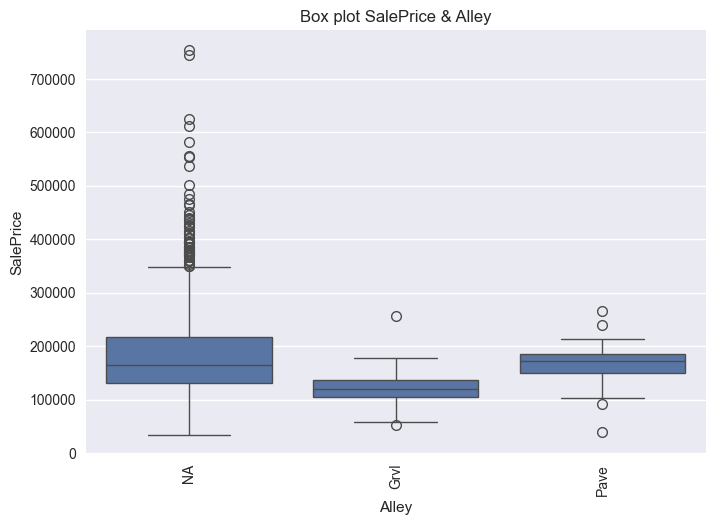

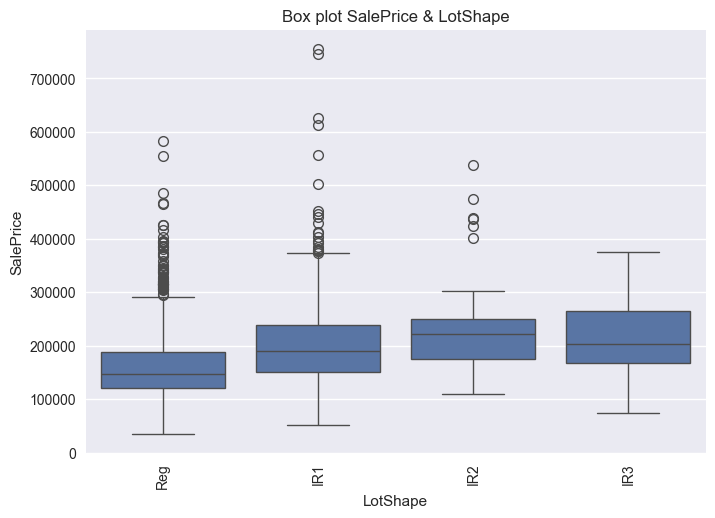

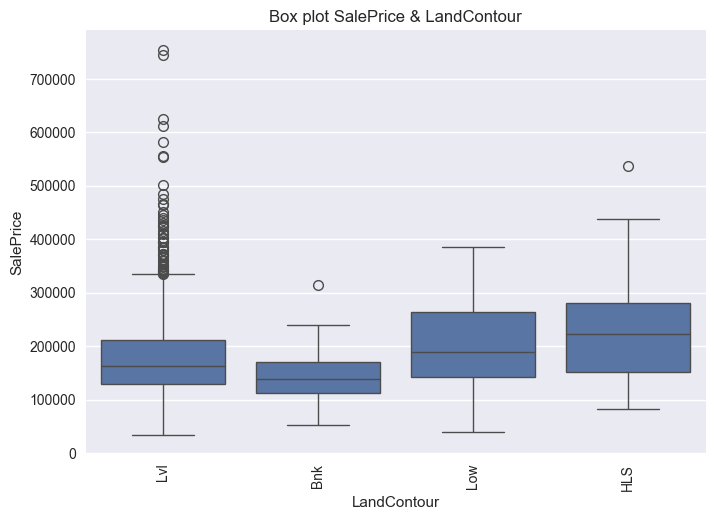

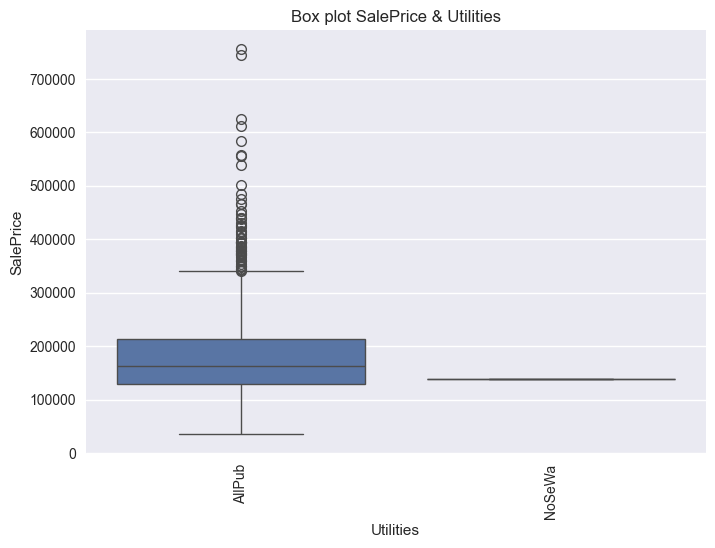

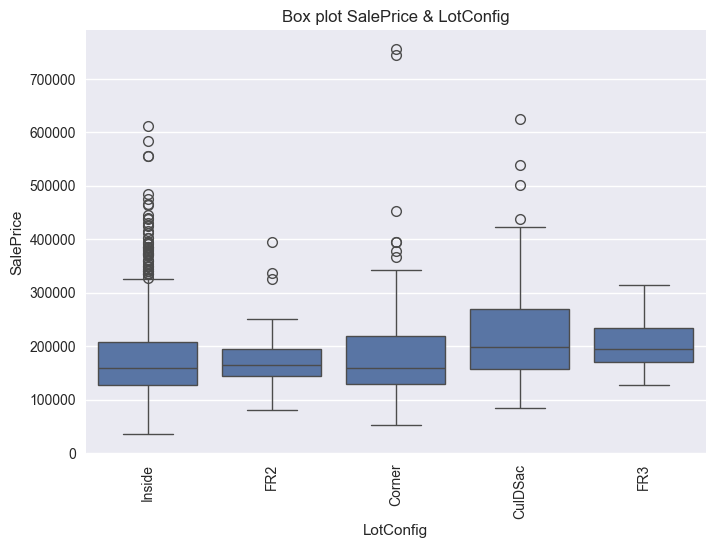

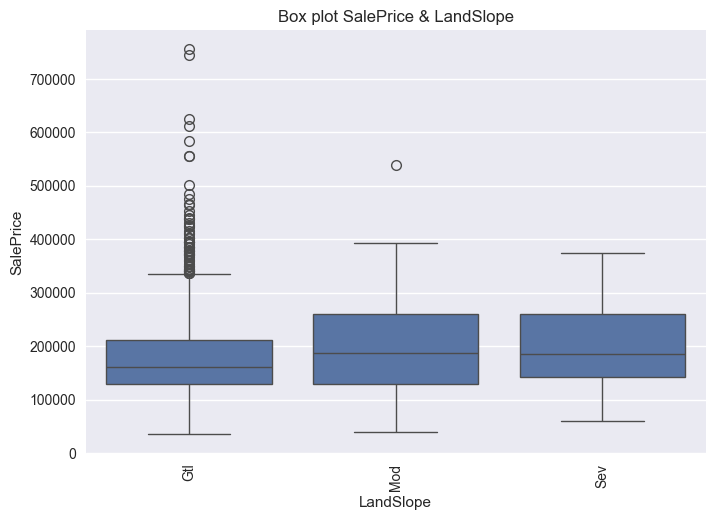

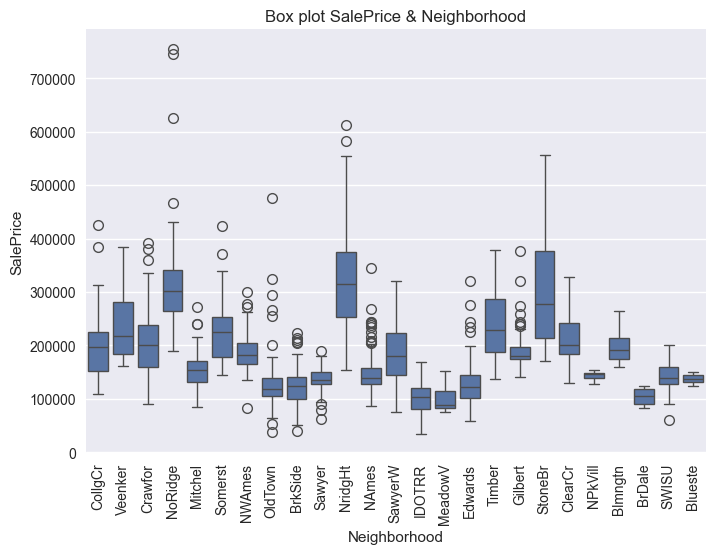

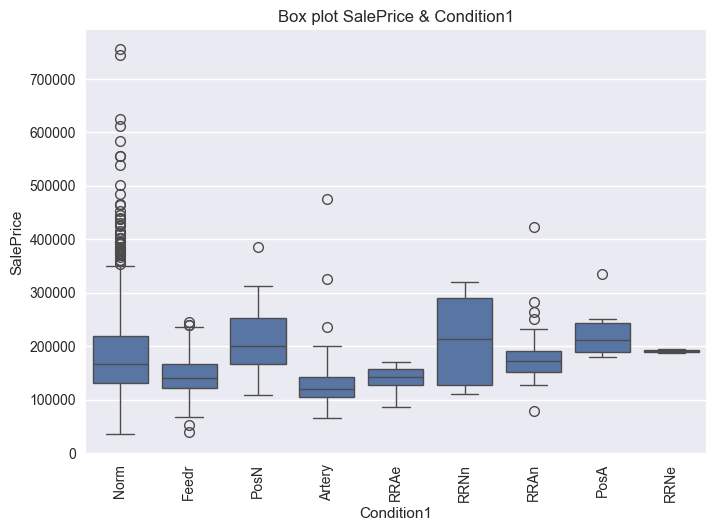

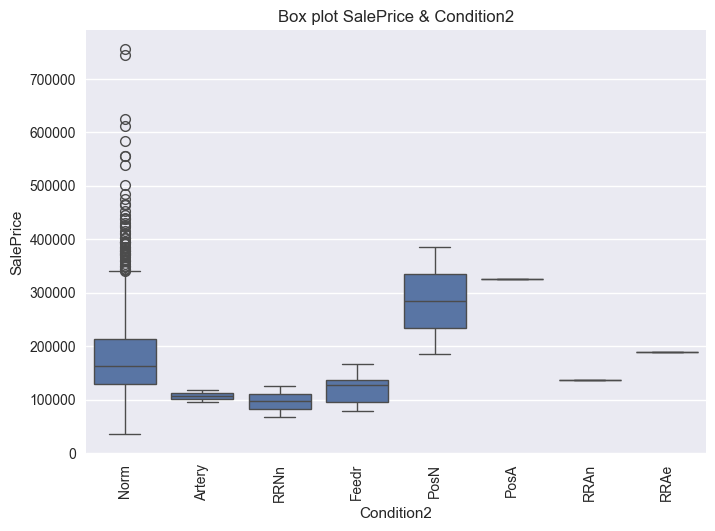

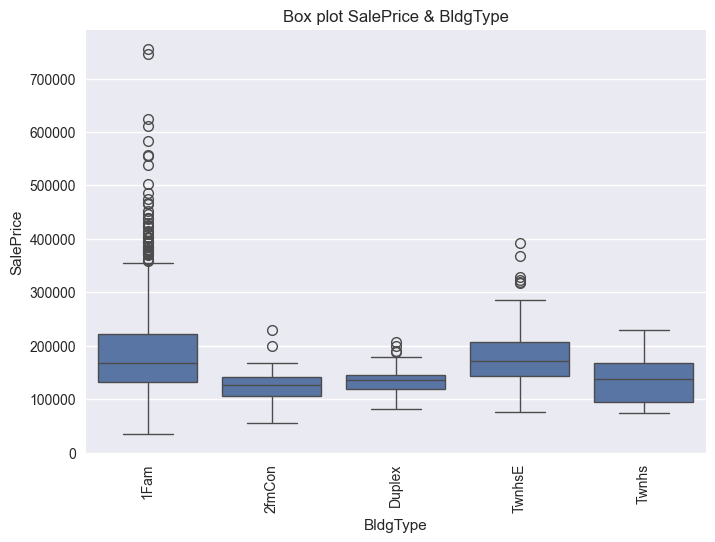

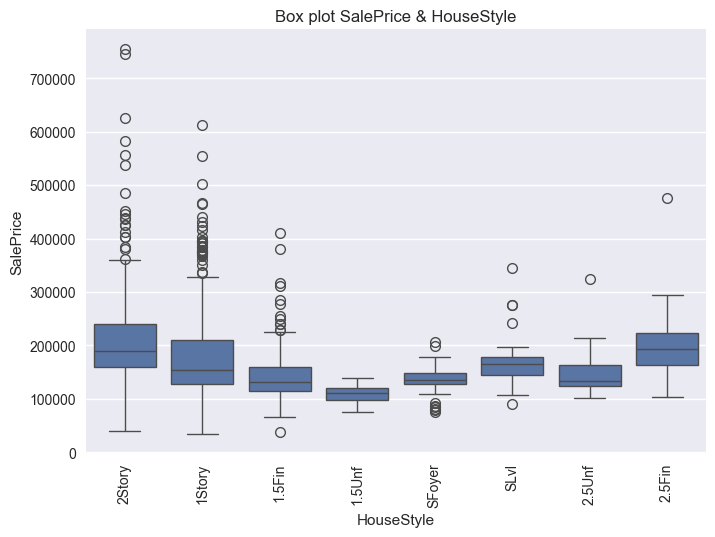

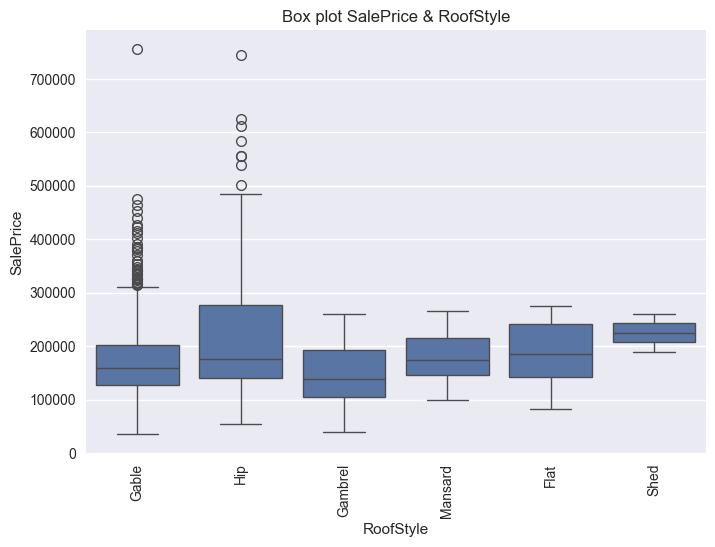

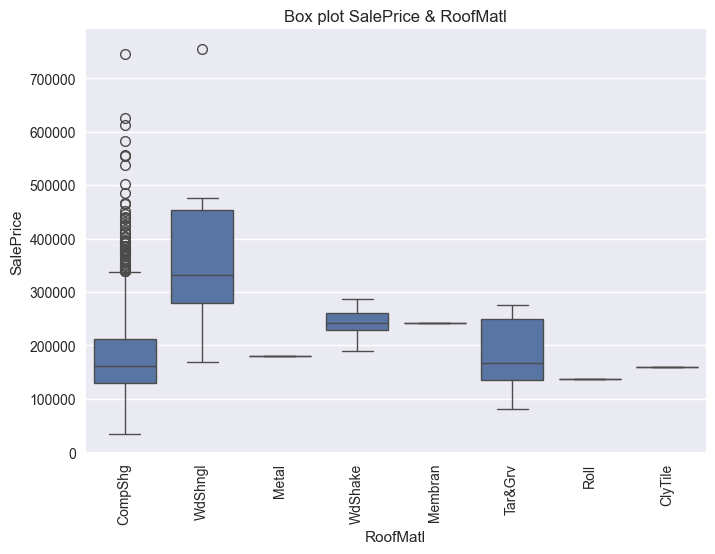

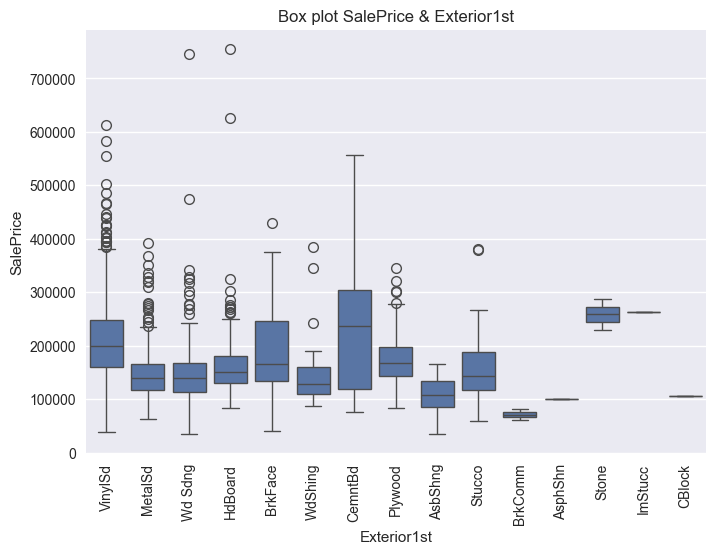

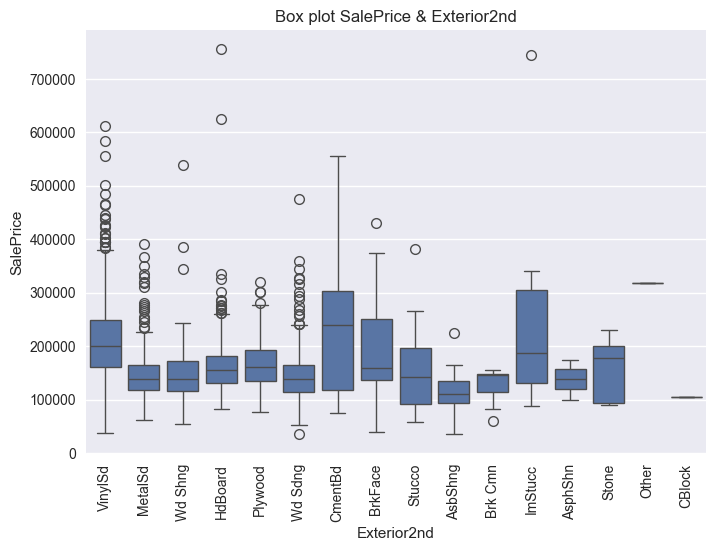

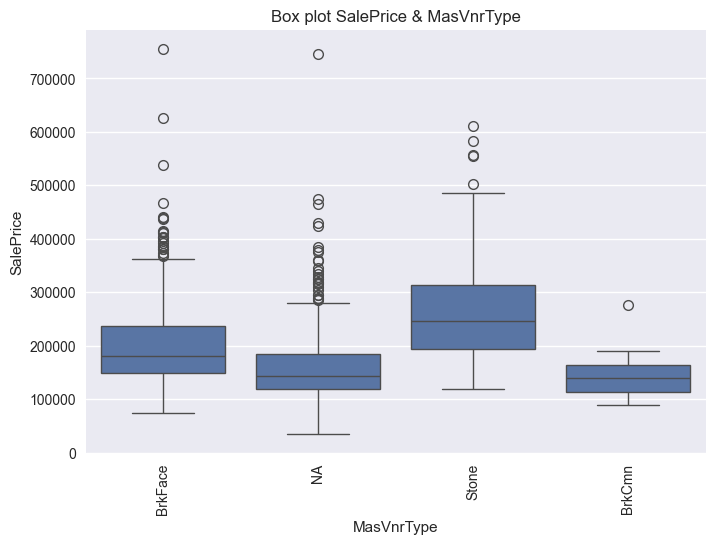

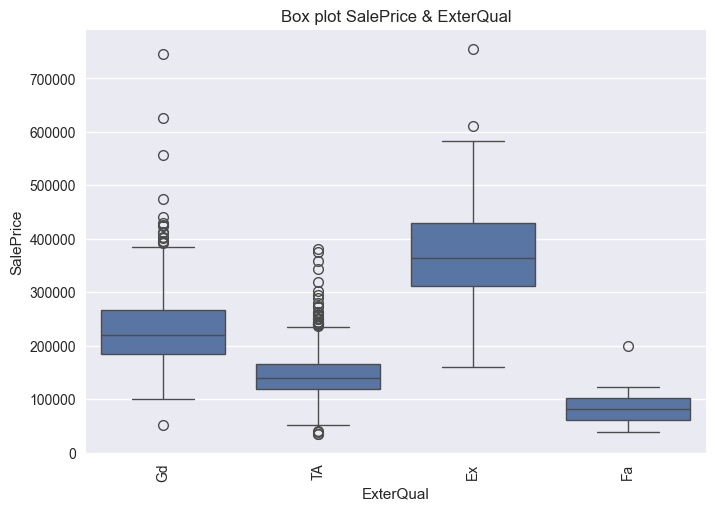

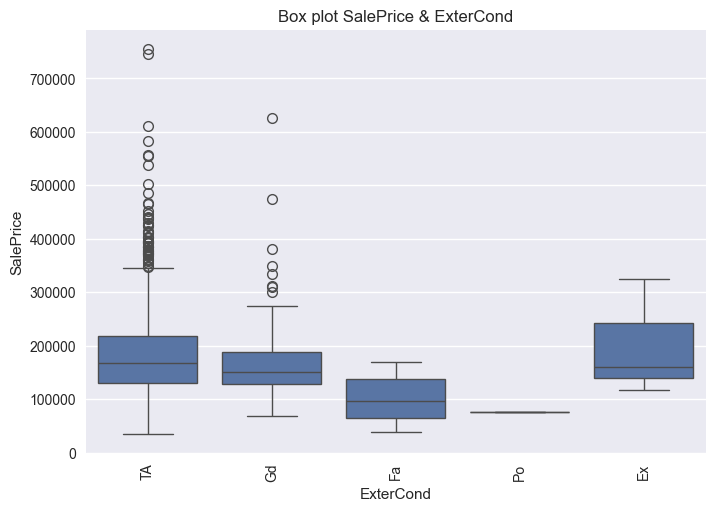

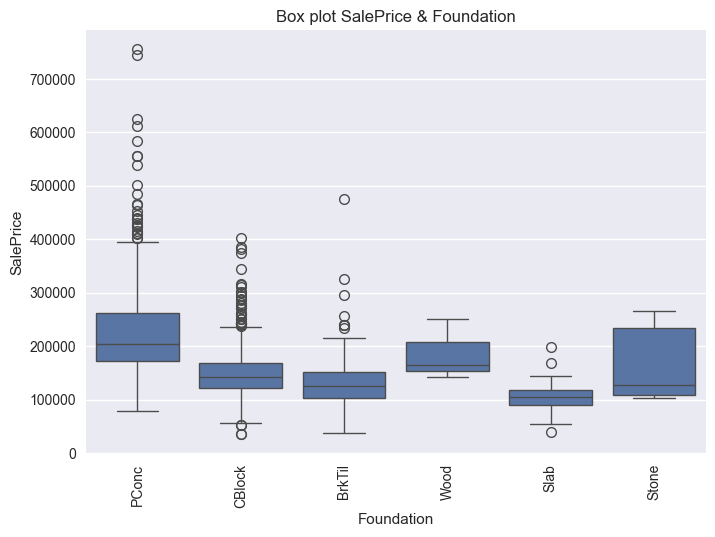

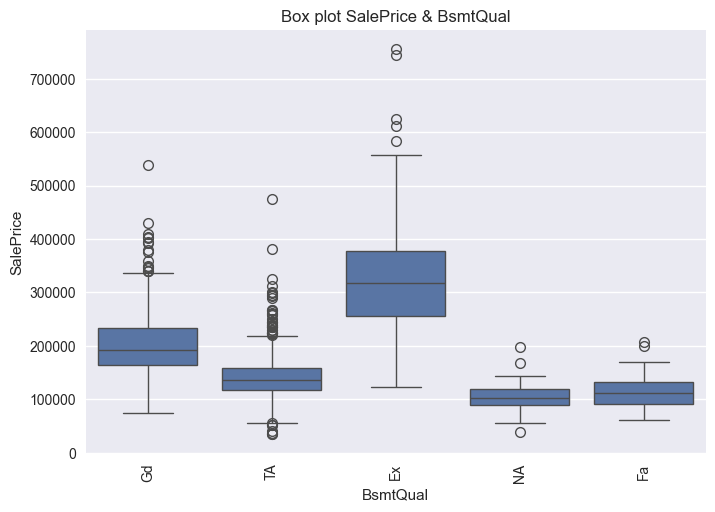

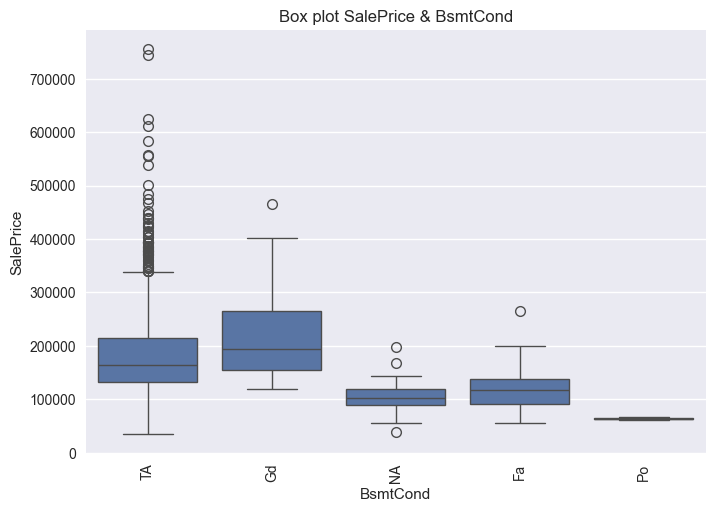

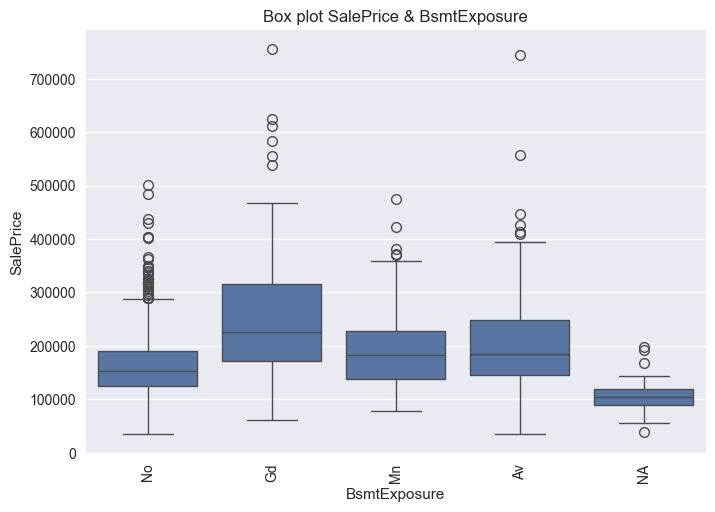

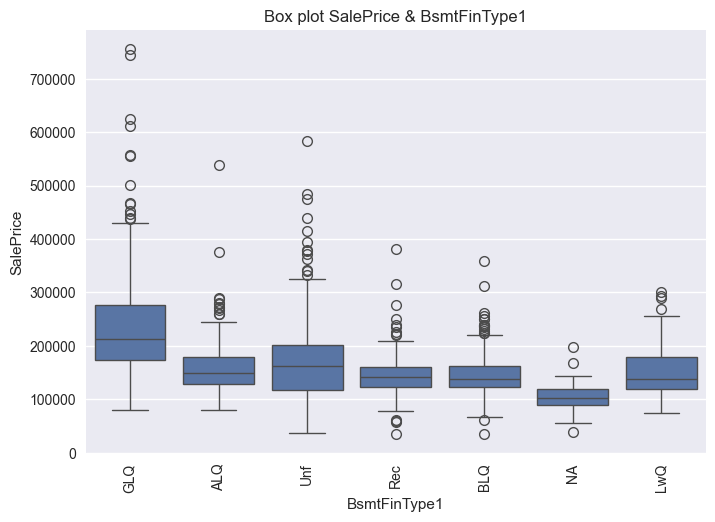

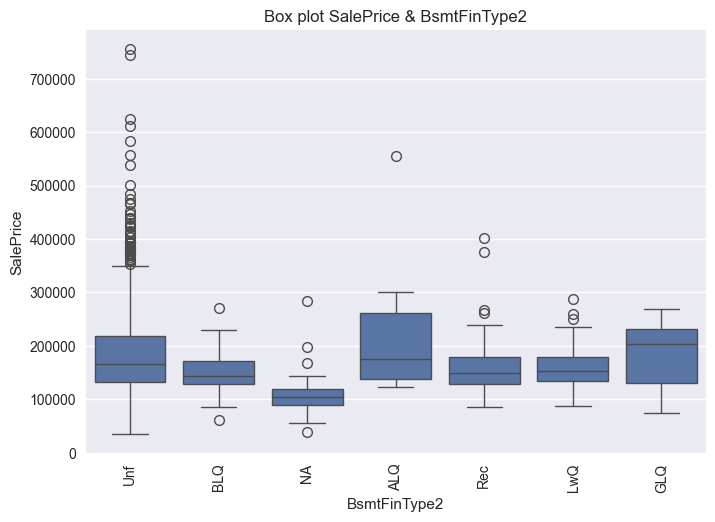

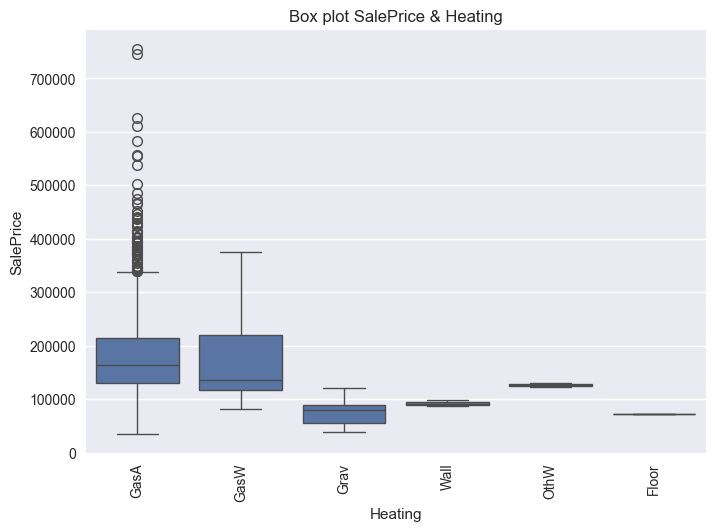

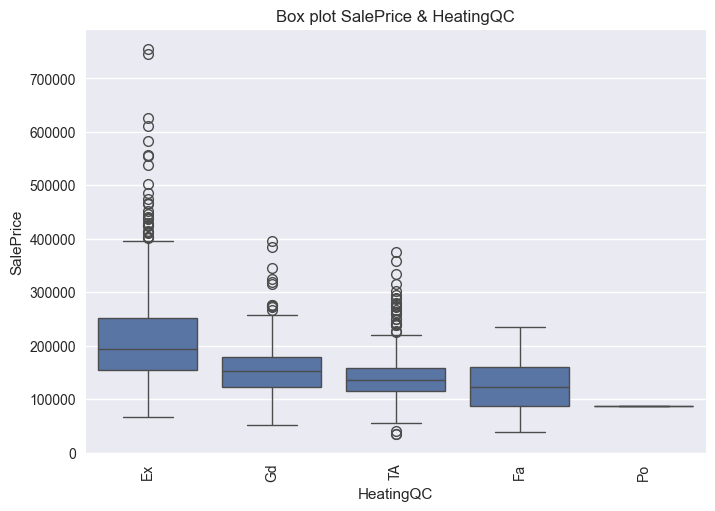

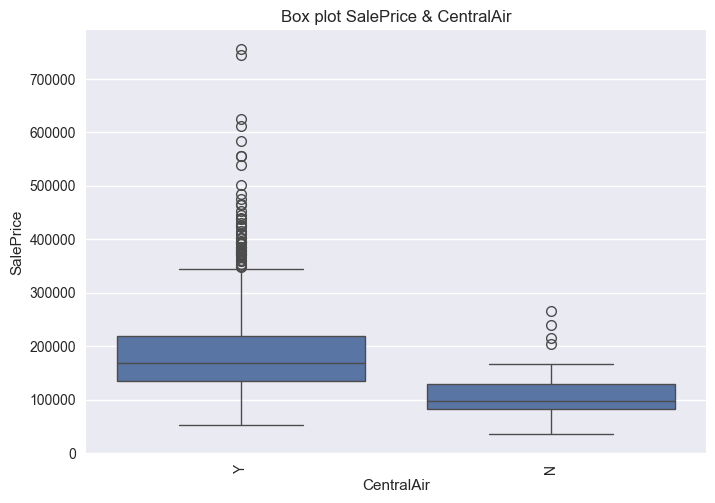

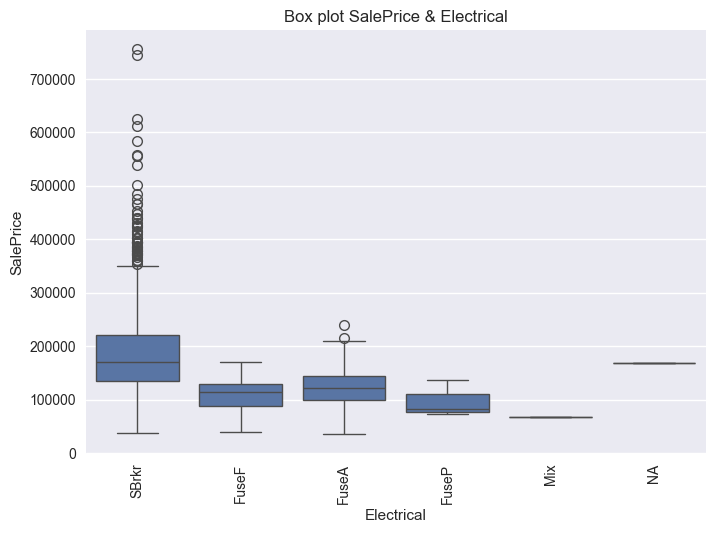

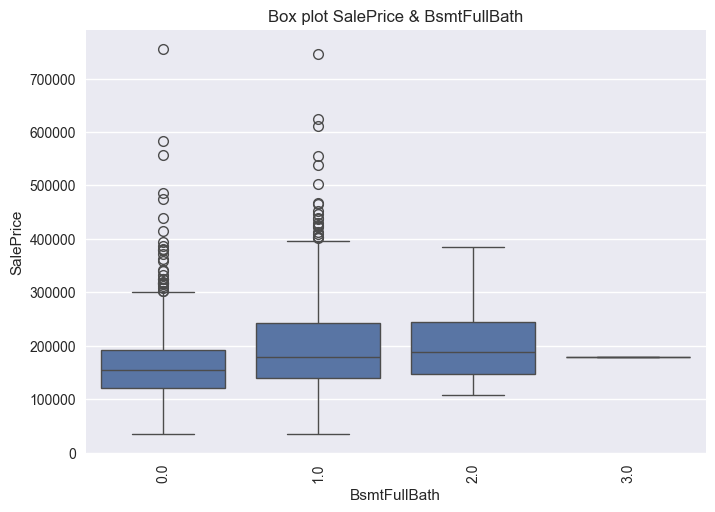

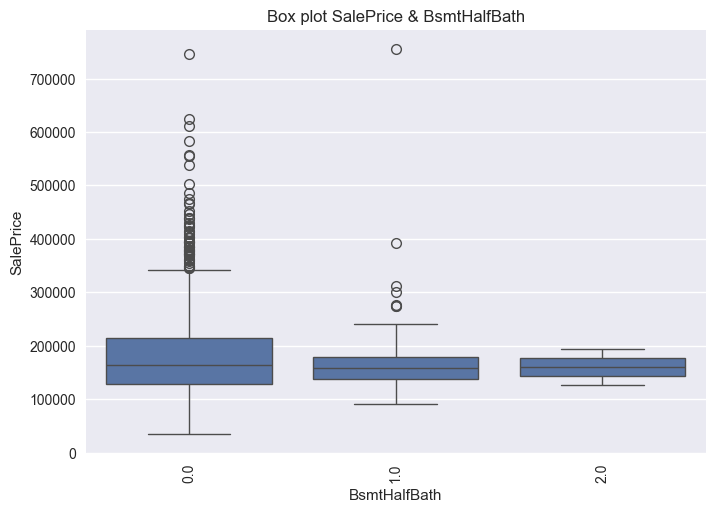

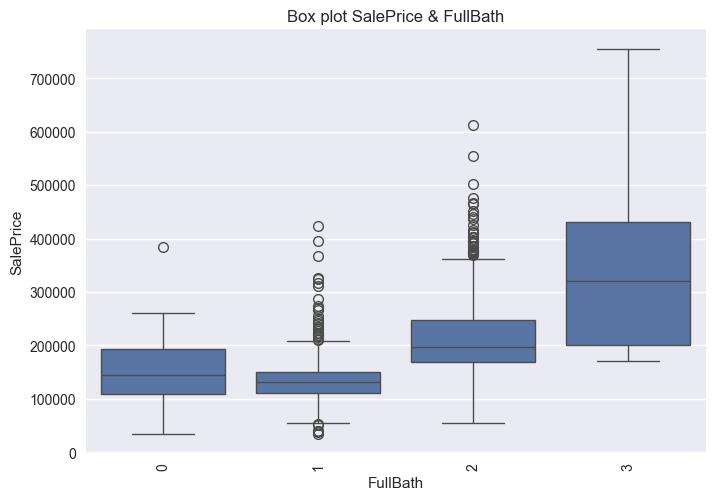

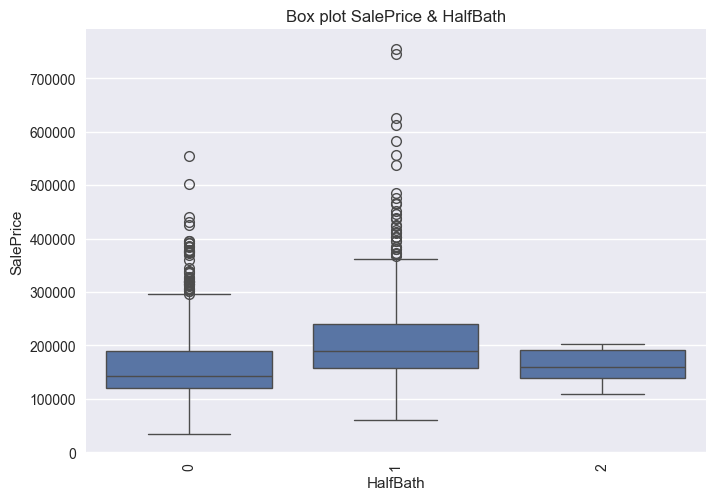

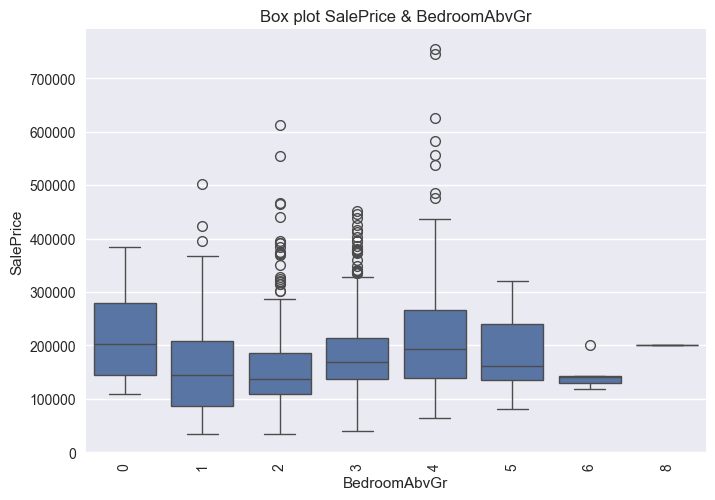

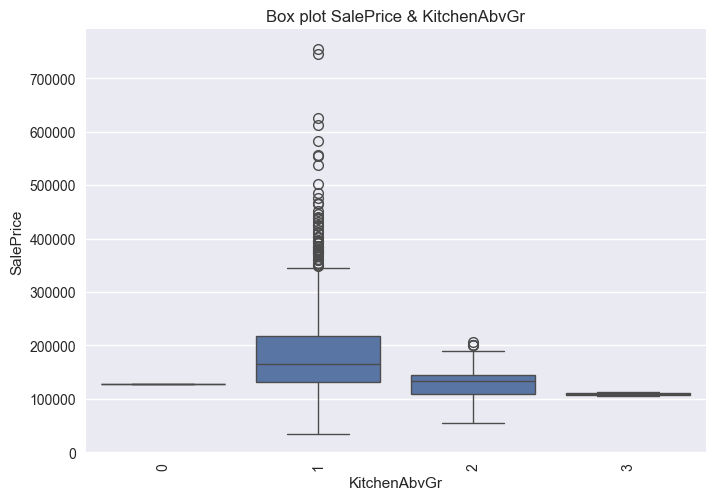

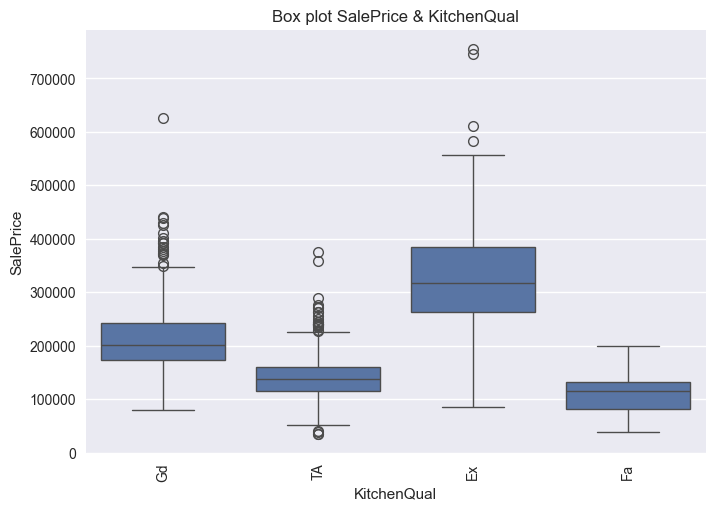

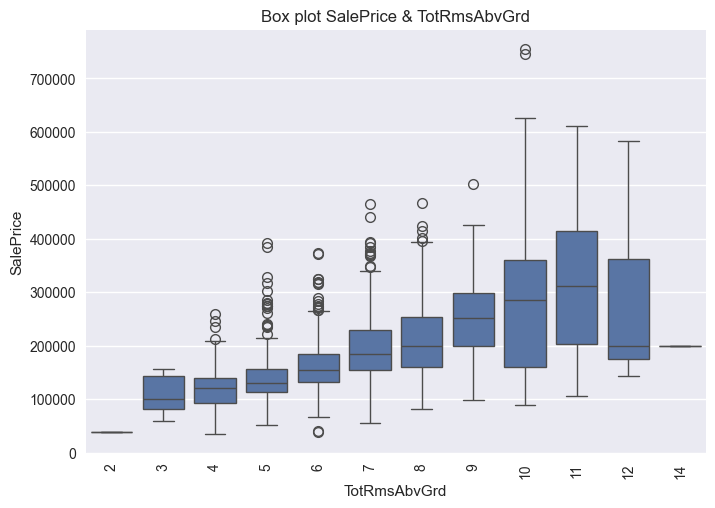

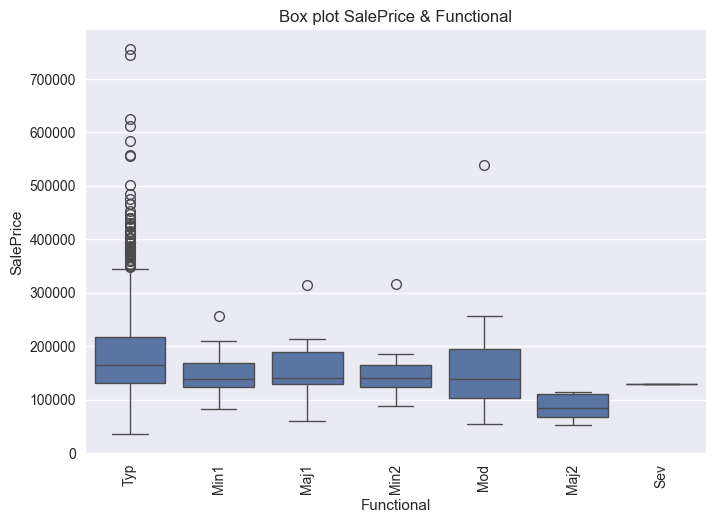

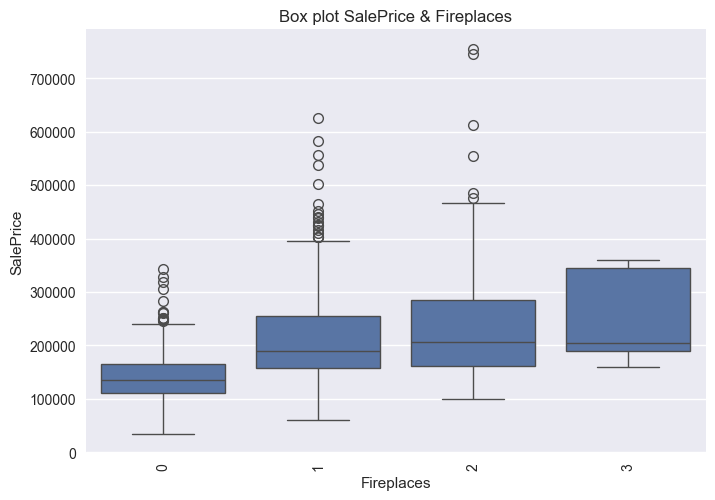

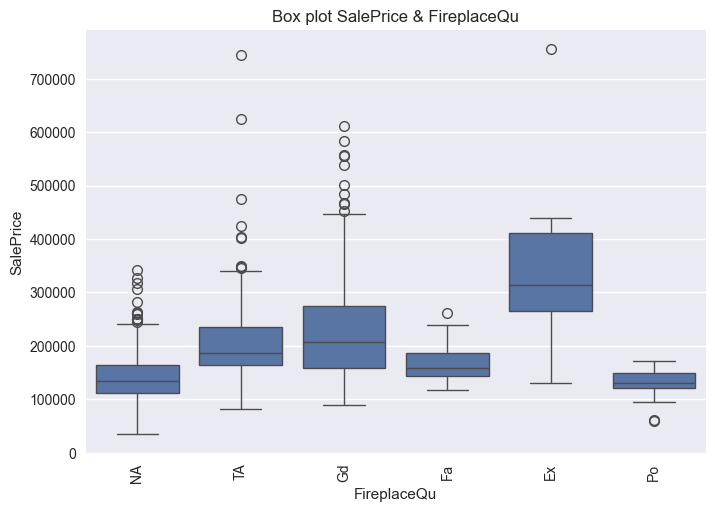

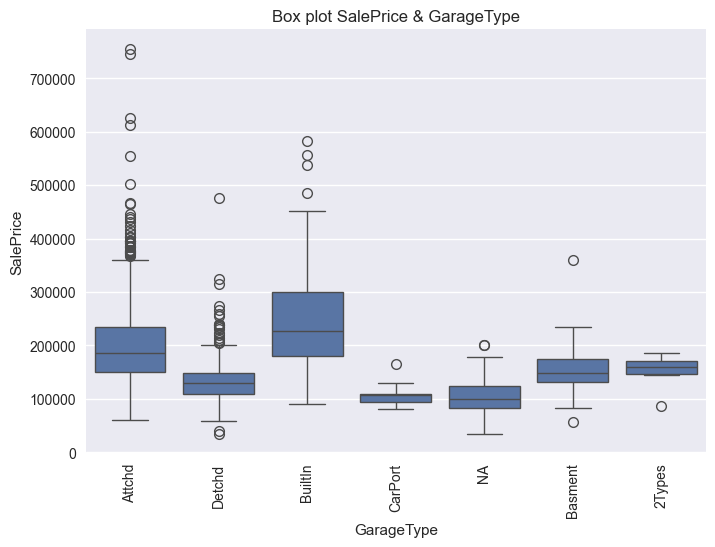

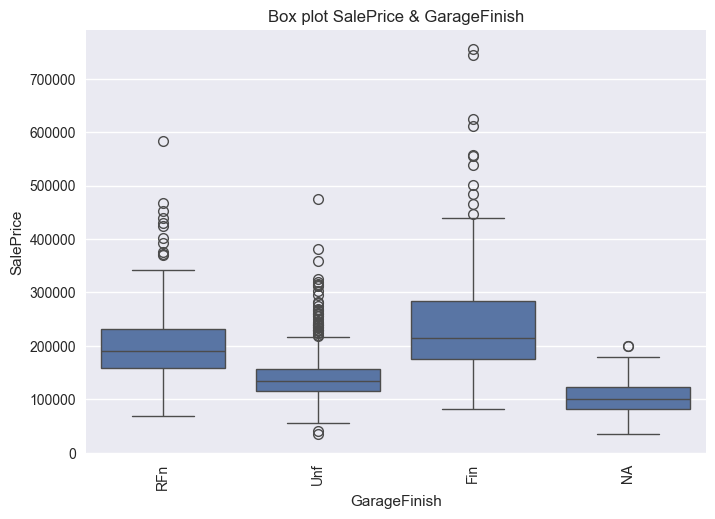

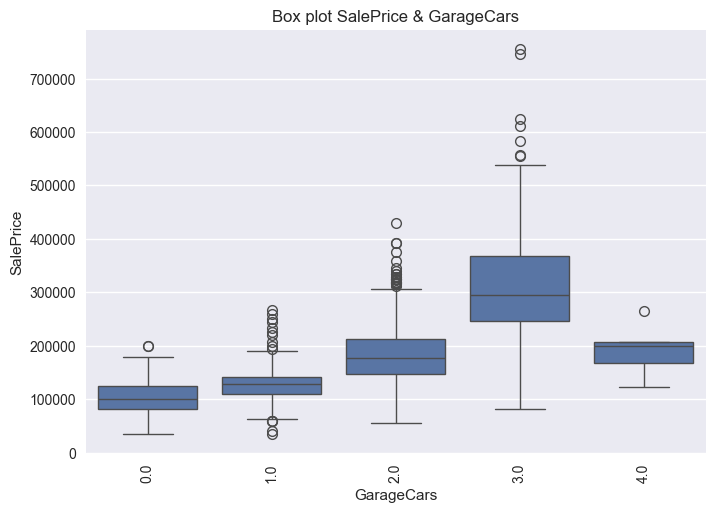

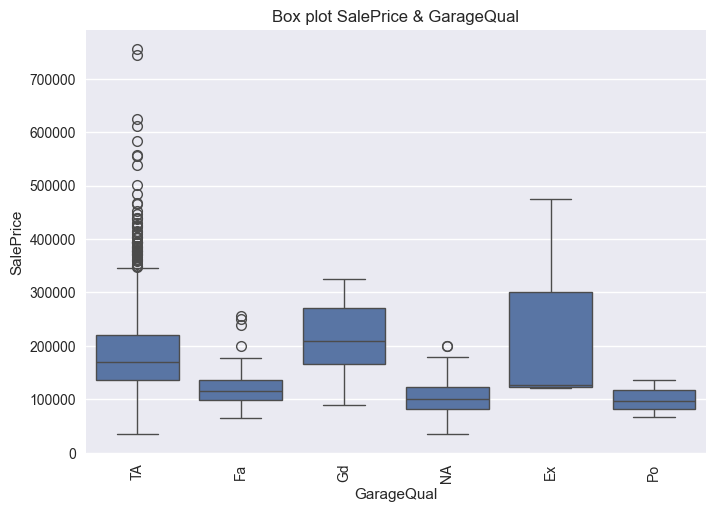

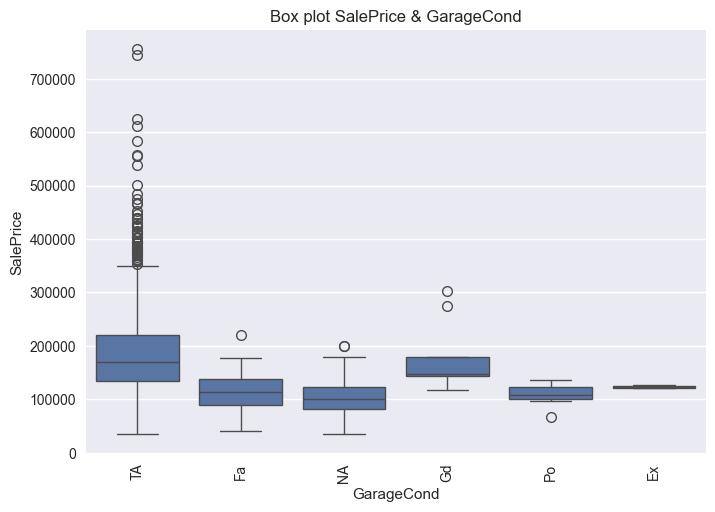

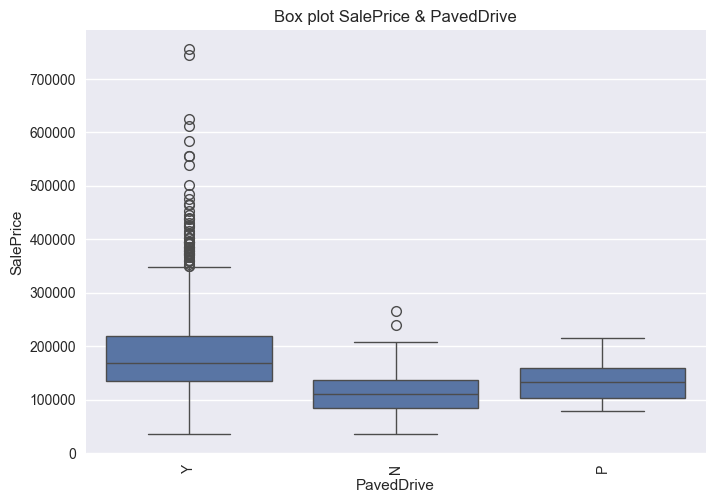

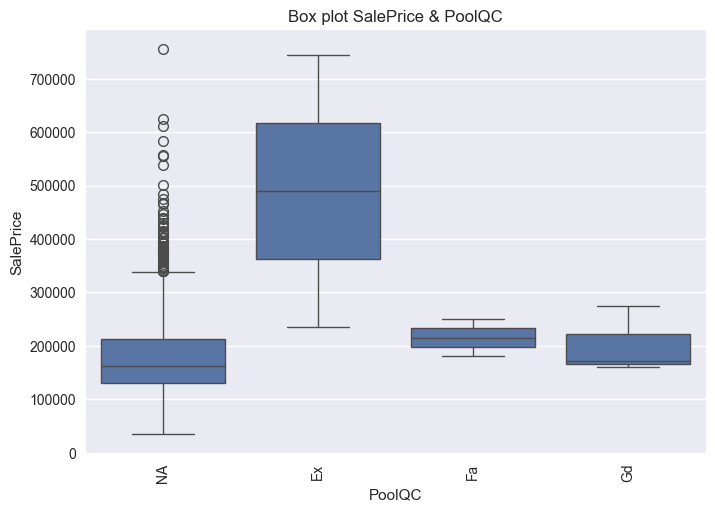

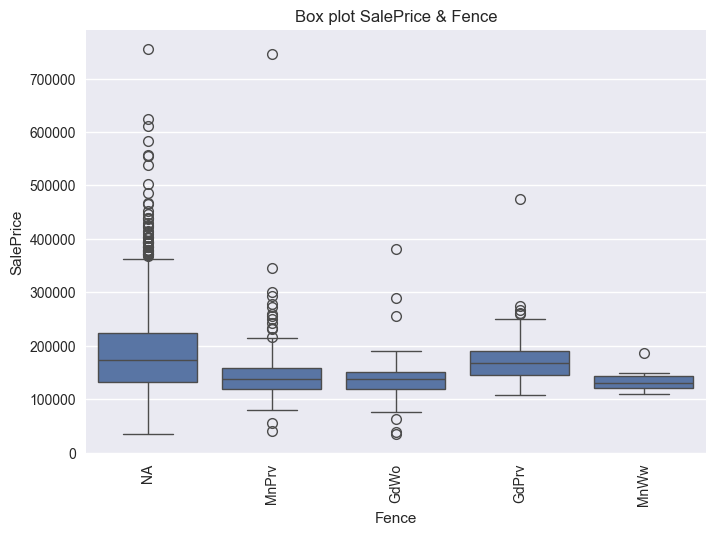

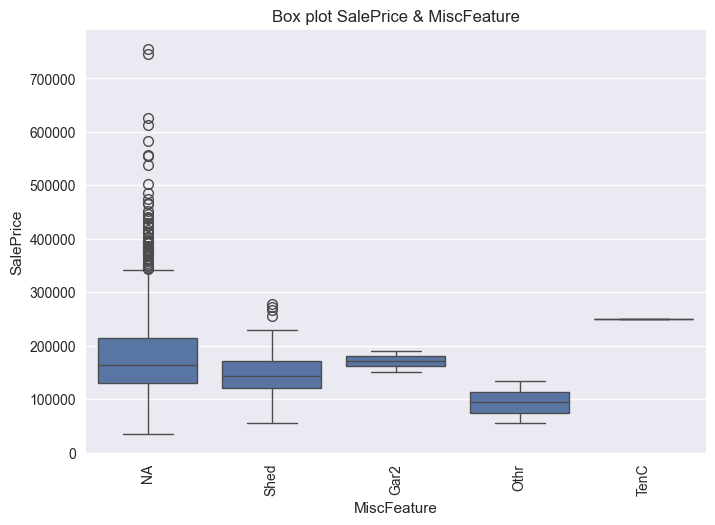

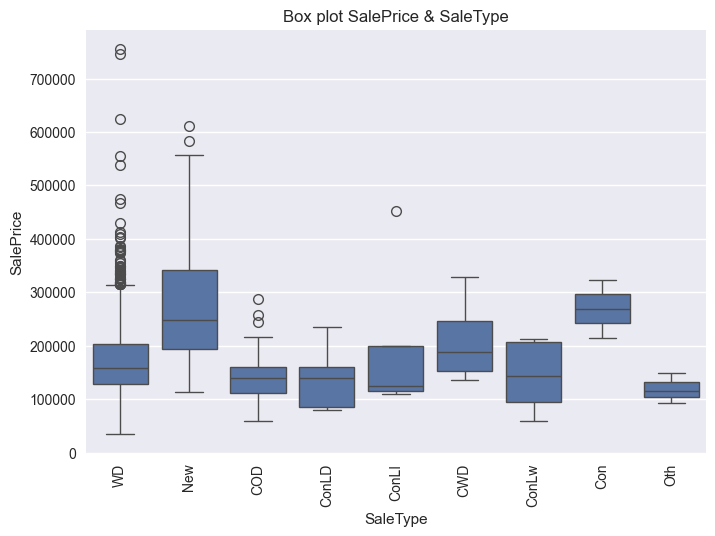

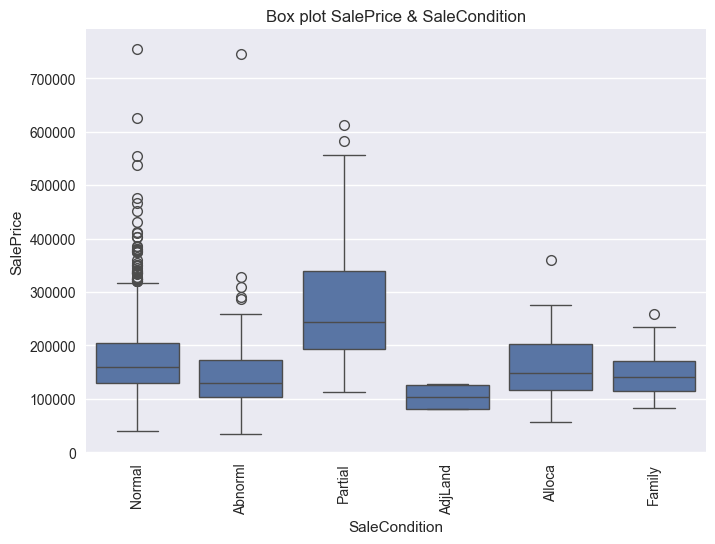

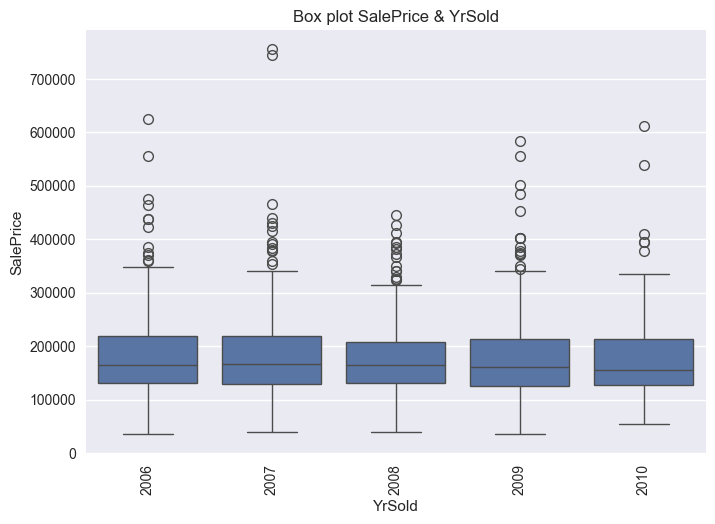

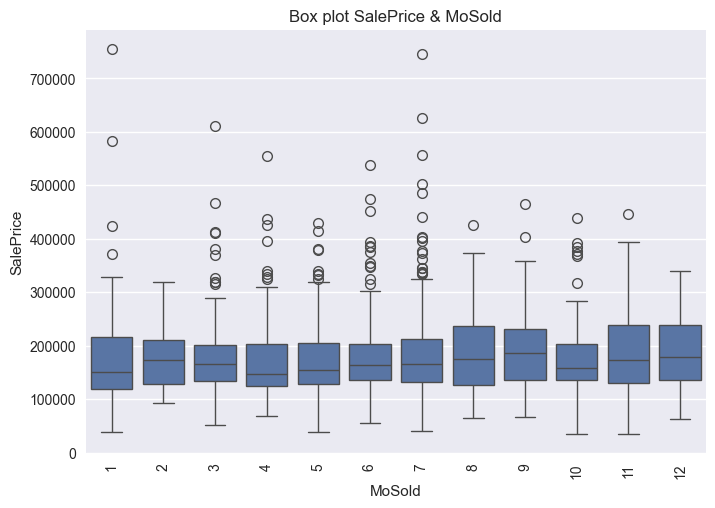

In [28]:
box_plots(train_clean['SalePrice'], train_clean, categorical)

# Baseline Model Engineering

Let's now create our model. We shall start with a simple baseline model and then increase complexity.

## 2.1 Basic Data Engineering

In order to perform a regression analysis, we need to prepare a little bit more our dataset. In particular, we will transform categorical variables into numeric.

An interesting trick in our regression scenario is to replace the category with the **mean** of our target variable for this category. This transformation creates then a natural correlation between our new variable and our target variable. Another (dummy) approach would be to use simply pd.getDummies(), but it's not that effective and deceiving in my opinion.

In [29]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

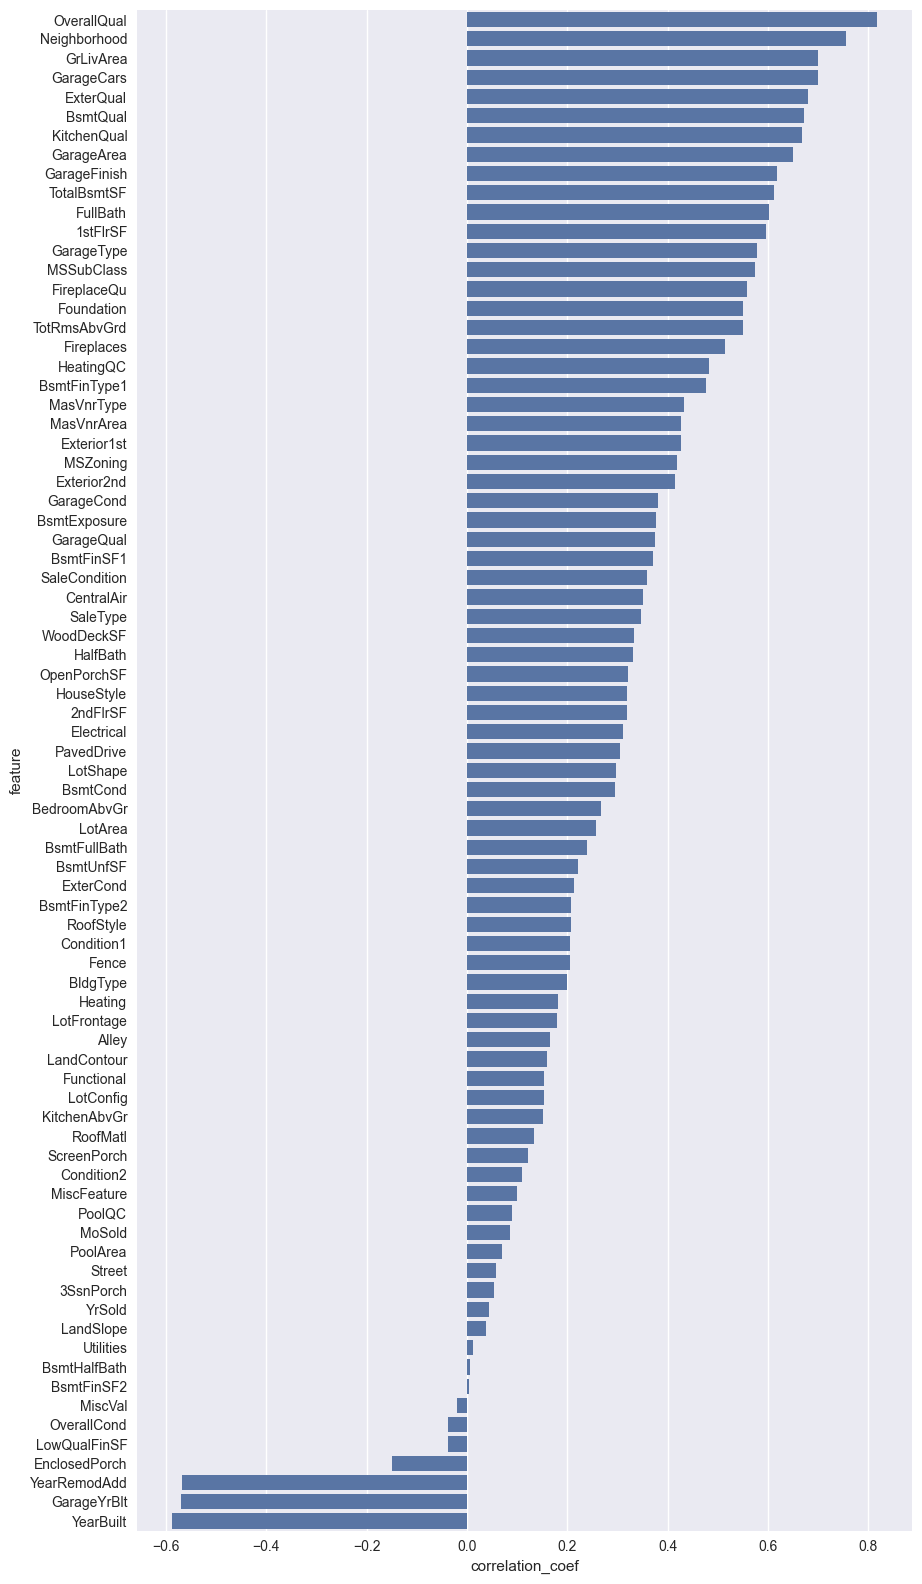

In [30]:
data_preprocess = encode_with_mean(data_clean, target, categorical)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_raw.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(validation_raw.index)]

cor = correlation(target, train_preprocess, numeric + categorical)

We see that many features correlates with the **logarithm of the SalePrice**, which is good for our use case. Let's have a look at the internal correlation between variables. We limit our visualisation for feature that has a moderate correlation or higher (i.e. correlation coefficient above 0.5 in absolute value).

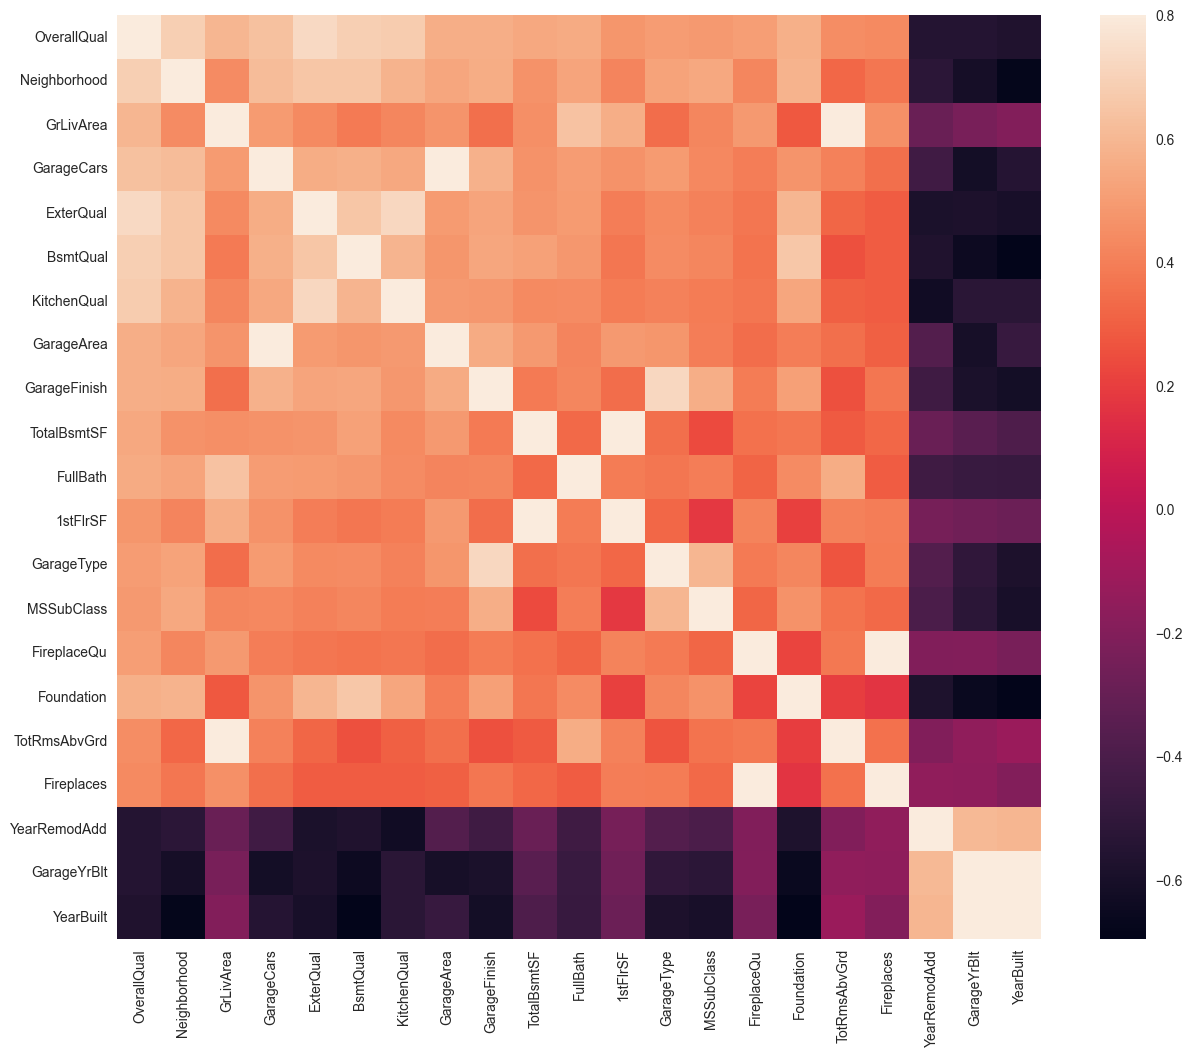

In [31]:
cols = cor[abs(cor['correlation_coef']) > 0.5]['feature'].tolist()
correlation_matrix = train_preprocess[cols].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

There is a lot of internal correlation. Hence we will need to select carefully variables in order to avoid multicolinearity.

## 2.2 Baseline Model - Linear Regression

We start with the most basic model among all, namely the linear regression. From our analysis, and our business understanding of the housing market, it's interesting to consider the following variables:

- OverallQual
- Neighborhood
- GrLivArea
- TotalBsmtSF
- YearBuilt

This makes complete sense, because these are the primary variable one will look for a house, namely overall quality of the good, the neighborhood, the living area and the year the hous was built. The basement is particularly important in Ames because it'a region with a high risk of tornado.

In [32]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

To fit the linear regression, we use the library StatsModels which comes with very handy functions for model understanding.

In [33]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:58:01   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

### Linear Regression Assumptions

If we want to use a linear regression, we need to check certain assumptions, namely :

- Linearity of the link between the independant variables and the depedant variable
- Residuals are normally distributed around 0
- Homoscedasticity
- Residuals are free of structure
- Residuals are free of outliers

The following is a code I've found https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/ which does this very well.

In [34]:
from statsmodels.graphics.gofplots import ProbPlot
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]));
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]));
    
    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]));
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rm/zd360c_n3394v5zq_gnyj9s00000gn/T/ipykernel_6235/2222118861.py:92: SyntaxWarning: invalid escape sequence '\s'
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


/Users/levkiwi/Dev/64-61.1-Data-Science/.venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


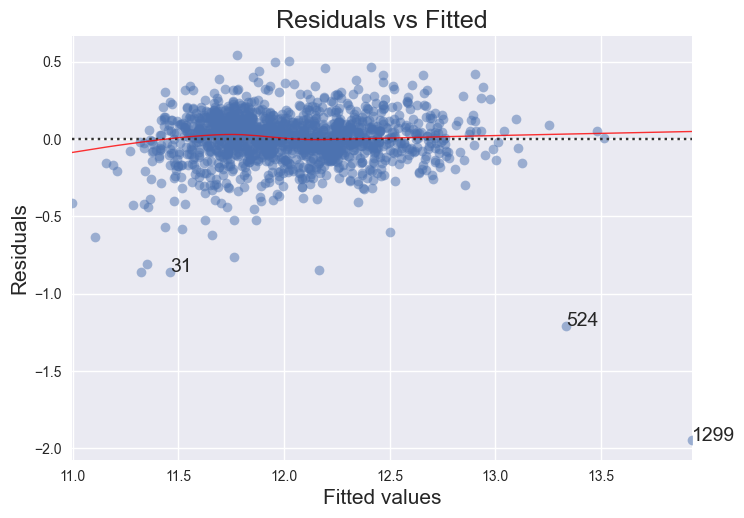

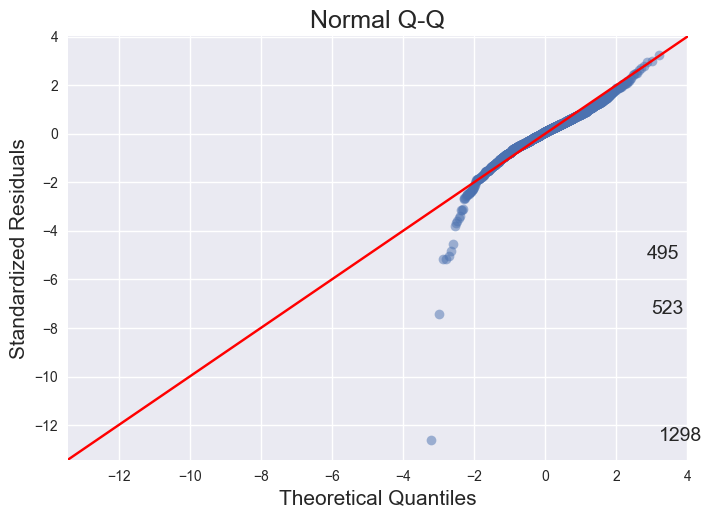

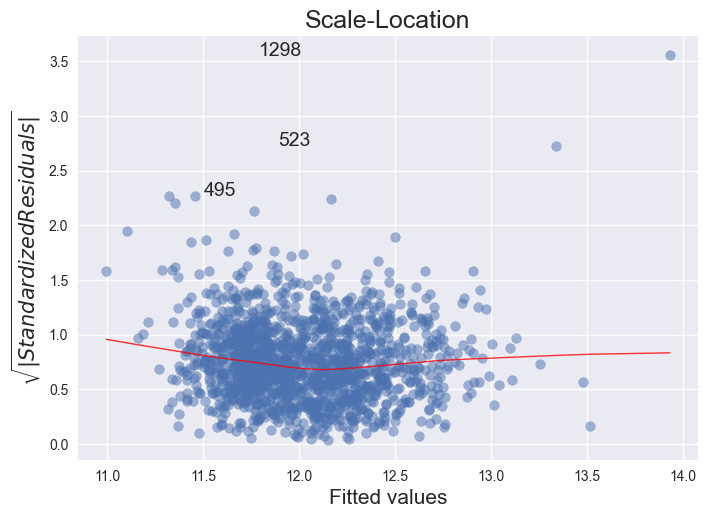

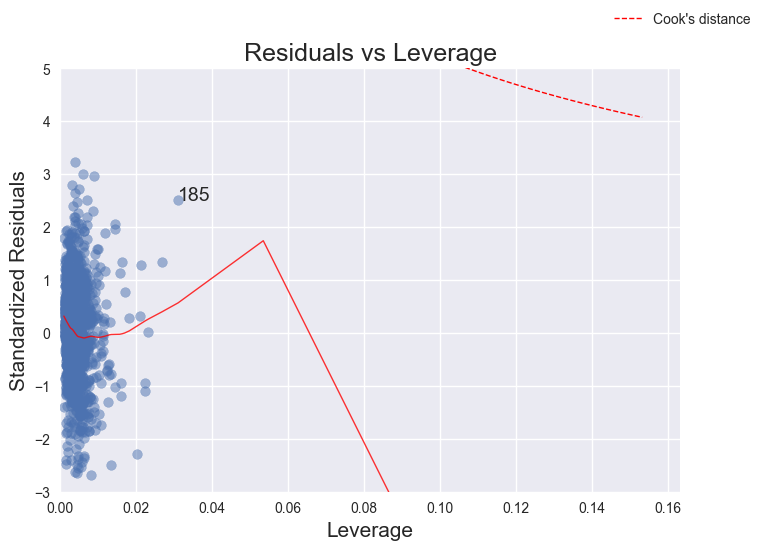

In [35]:
diagnostic_plots(sm.add_constant(X), y)

#### Residuals Analysis

The residuals look free of structure and seems normally distributed around 0. However, we observe some outliers in the residuals. Let's have a look at these data.

In [36]:
print(X[base].iloc[[523, 1298]])

      OverallQual  Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                                
524            10     11.712321       4676       3138.0          0
1299           10     11.712321       5642       6110.0          0


In the documentation (http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), we can read 

_SPECIAL NOTES:
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students._

Thus, let's have a look at the outliers, especially on the column **GrLivArea**.

In [37]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

We will now run the same code as above, without the outliers

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:58:02   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

/Users/levkiwi/Dev/64-61.1-Data-Science/.venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


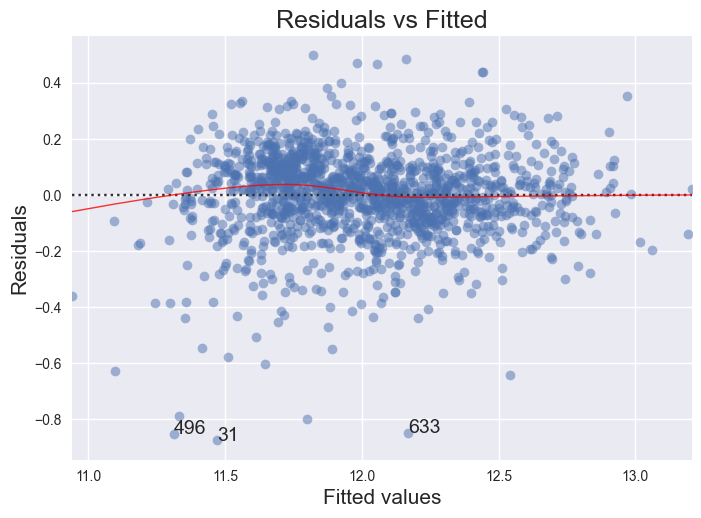

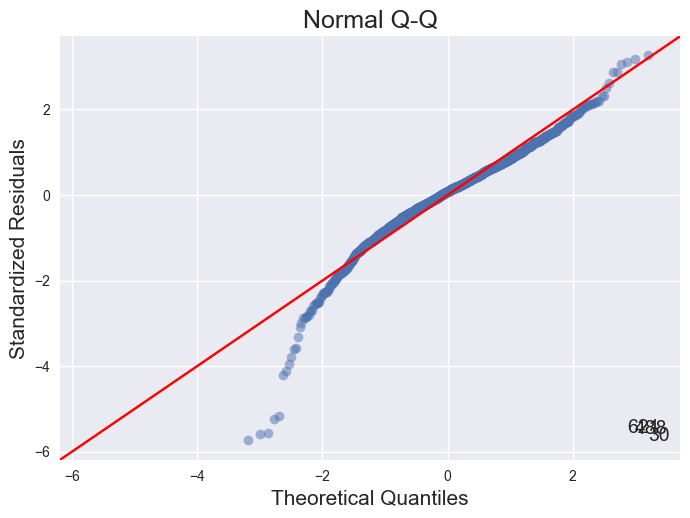

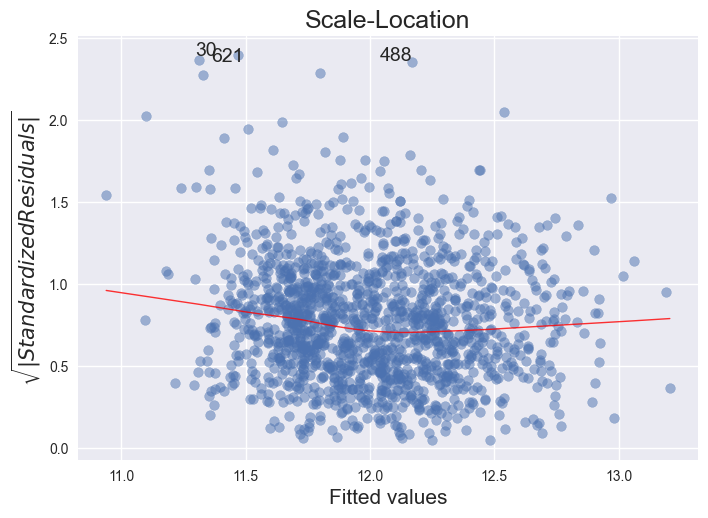

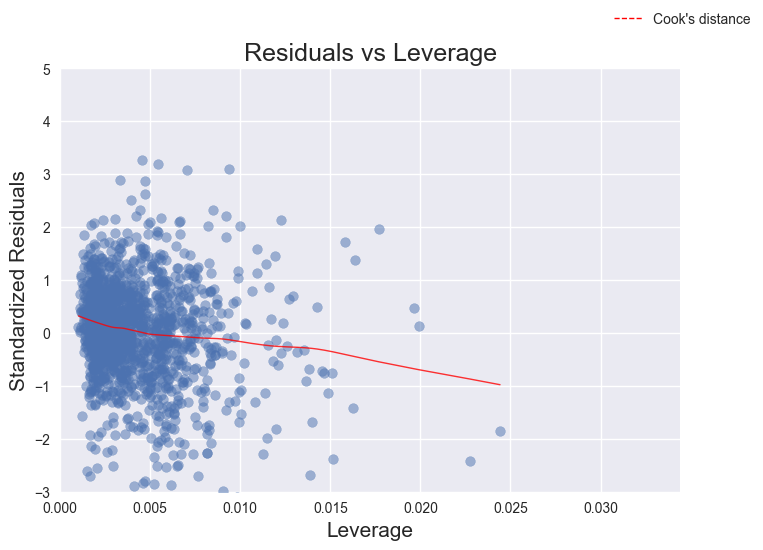

In [38]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

Ok, that's way better. Let's now evaluate our baseline model and see how well that will perform on Kaggle. We will use the **predict** method to perform this.

In [39]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.214534
2    12.081588
3    12.244451
4    12.046219
5    12.620316
dtype: float64


We shall vizualise the scatter plot where we compare the actual value vs the predicted values.

In [40]:
def plot_prediction(actual, predicted) :
    
    data = pd.concat([actual, predicted], keys = ['actual', 'predicted'], axis = 1)

    plt.title('Actual vs Predicted')
    sns.regplot(x = 'actual', y = 'predicted', data = data)
    plt.show()

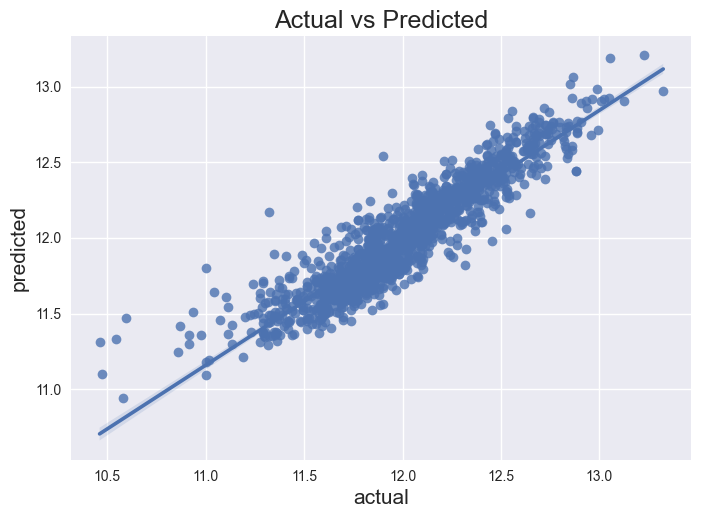

In [41]:
plot_prediction(y, y_pred)

This seems to work fine. Beware of overfitting here, since we predicted and fit on the same dataset. For more complex models, that might be a serious issue.

In [42]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))

In [43]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.15247508062910983


## 2.3 Baseline Model submission on Kaggle

We use the **predict** method on the validation dataset

In [44]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.663271
1462    11.946171
1463    12.025787
1464    12.101195
1465    12.341289
dtype: float64


We write now our predictions in the _baseline.csv_ file and don't forget to use the inverse function of **np.log1p**, namely **np.expm1**.

In [45]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('Data/baseline.csv', index = False)

<img src="Img/baseline.jpg" width=800 />